<a href="https://colab.research.google.com/github/shahzorkhan/LaborProject/blob/main/Job_Task_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jobs  and Tasks: Mapping, proximities, Task space and Job complexity in R
================================================================================



21 February 2022, Shahzor Khan (shahzor@mit.edu)



## Notes



Google colab link Python:

[https://colab.research.google.com/github/matteha/product-space-eci-workshop/blob/main/product-space-eci-workshop.ipynb](https://colab.research.google.com/github/matteha/product-space-eci-workshop/blob/main/product-space-eci-workshop.ipynb)

Google colab link in R:
[https://colab.research.google.com/github/matteha/product-space-eci-workshop/blob/main/product-space-eci-workshop-in-R.ipynb](https://colab.research.google.com/github/matteha/product-space-eci-workshop/blob/main/product-space-eci-workshop-in-R.ipynb)

To run code in Google Colab, you need a Google account.



## Outline of lab session



We&rsquo;ll cover:

-   Introduction to Onet data

-   Calculating Main Taskss, co-occurences and proximities
    -   Task and technology proximities
    -   Trade: specialization of Tasks over time
    --   Technologies (patents): specialization of countries and US cities over time

-   Task space visualization

-   Calculating Task Complexity / Job Complexity (by destination)



## Job data



### Background



Onet Data maintains relevance of Jobs to Tasks, job requirements, work experience etc using survey data. The job titles etc is updated frequently to map the current status. https://www.onetcodeconnector.org/

Jobs and Task are a important field of study, especially by Daron Acemoglu and Pascual Restrepo in terms of Technological replacement and classifying impact of automation, (Good Automation vs Bad Automation)

---
The product space is, as well as its derivations / related measures such as economic complexity and the Growth&rsquo;s annual rankings of countries by economic complexity (at [https://atlas.cid.harvard.edu](https://atlas.cid.harvard.edu)), are based on trade data between countries.

The Growth Lab maintains and periodically updates a cleaned version of trade data at Harvard Dataverse:

[https://dataverse.harvard.edu/dataverse/atlas](https://dataverse.harvard.edu/dataverse/atlas)

This dataset contains bilateral trade data among 235 countries and territories in thousands of different products categories (a description of the data can be found at: [http://atlas.cid.harvard.edu/downloads](http://atlas.cid.harvard.edu/downloads)).

How does the data look like? We will explore the data in R whilst mainly using the &rsquo;tidyverse&rsquo; packages (most popular R packages for data analysis).



#### Footnote on trade and services (ICT, tourism, etc.):



-   Services and tourism are included in the Growth Lab&rsquo;s Atlas and trade data as well as of September 2018. See announcement at:

[https://atlas.cid.harvard.edu/announcements/2018/services-press-release](https://atlas.cid.harvard.edu/announcements/2018/services-press-release)

Obtained from IMF, trade in services covers four categories of economic activities between producers and consumers across borders:

-   services supplied from one country to another (e.g. call centers)
-   consumption in other countries (e.g. international tourism)
-   firms with branches in other countries (e.g. bank branches overseas)
-   individuals supplying services in another country (e.g. IT consultant abroad)



### Install and Load necessary R packages



In [183]:
print('installing packages, takes some mins on Google Colab')

package_list <-
  c(
    "tidyverse",
    "reticulate",
    "foreign",
    "png",
    "economiccomplexity",
    "tidylog", # For Original
    "igraph",
    "viridis",
    "umap",
    "tidygraph",
    "ggraph"
  )
# Check if packages are already installed, otherwise install them
to_install <-
  package_list[!(package_list %in% installed.packages()[, "Package"])]
if (length(to_install)) {
  install.packages(to_install)
}
print('done installing packages')

#library('arrow') # for reading parquet etc.
library('foreign') # to load STATA files into R
library('glue') # to concatenate strings / variables
library('png') # to load / show image files
library(tidylog, warn.conflicts = FALSE) # for join statistics, e.g. left_only
library('economiccomplexity')
library("reticulate") # R - Python interaction
# -- if reticulate throws error on OSX, run: brew install xquartz --cask
library('repr') # to change IRkernel properties (R kernel in Jupyter Notebook)
library('tidyverse') # data analysis standard toolkit

library(igraph)
library(viridis)
library(tidygraph)
library(ggraph)
library(umap)

#library('ONETr') # ONET toolkit for R
#library('readxl') # Excel Read toolkit

#library('tidyr') # for reshaping data (making it from long to wide format, and vice versa)
#library('dplyr', warn.conflicts = FALSE) #for manipulating tibbles (or data frames); creating new variables, calculating summary statistics etc.
# -- readr: for reading data
# -- ggplot2: for plotting
# -- tibble: for creating “tibbles”; these are the tidyverse’s take on data frames.
# -- purrr: for functional programming.
# -- stringr: for manipulating strings
# -- forcats: FOR CATegorical data (factors); this makes it easier to reorder and rename the levels in factor variables.
# -- library(datasets) # - Built in datasets
print('loaded libraries')


[1] "installing packages, takes some mins on Google Colab"
[1] "done installing packages"
[1] "loaded libraries"


### Download trade dataset and load into memory



Job data is constantly updated by the US Department of Labor, you can find the most recent version of the job data here: https://www.onetcodeconnector.org/

____

[https://dataverse.harvard.edu/dataverse/atlas](https://dataverse.harvard.edu/dataverse/atlas)

Below we&rsquo;re using the trade data using the HS classification (&rsquo;Harmonized System 1992&rsquo; - alternative is &rsquo;SITC - Standard Industrial Trade Classification&rsquo; which goes back further in time) at the 4 digit level (alternative is 2 or 6 - 6 has more detail). It can be found here:

[https://dataverse.harvard.edu/file.xhtml?fileId=4946953&version=4.0](https://dataverse.harvard.edu/file.xhtml?fileId=4946953&version=4.0)

The trade file we&rsquo;re using below has a fix implemented in the labels (strings) of the products - some products currently erronuously have the same strings (e.g. product codes 5209 and 5211 in Zimbabwe have the same product string). The file is regularly updated by the Growth Lab.

To load the data directly we&rsquo;re using a Dropbox link with the fix implemented (Dataverse normally requires one to fill in an agreement form first but see Section 1 (by Shreyas) on how to use the dataverse library in R to load data from there directly into R).

(The trade file is a large file because it includes country / product strings, takes 1 - 3 minutes to load. One can also merge strings in separately but for illustrative purposes it is easier to have them all preloaded - also to avoid memory problems that R quickly runs into).



In [184]:
print('loading jobs data - takes 1 - 3 mins')
#df_orig <- read_xlsx('https://www.dropbox.com/scl/fi/0cc6mlkau424eua5lqkur/Task-Ratings.xlsx?dl=0&rlkey=5yudx5zgpc9cnsp133r31xlrw')
task_rating_orig <- read_csv('https://www.dropbox.com/s/xbm7oqrcr5xz3ln/Task%20Ratings.csv?dl=1', col_names = TRUE, show_col_types = FALSE, quote = "\"")
task_dwa_orig <- read_csv('https://www.dropbox.com/s/4hfh3fnuojwlhbk/Tasks%20to%20DWAs.csv?dl=1', col_names = TRUE, show_col_types = FALSE, quote = "\"")
a_wa_orig <- read_csv('https://www.dropbox.com/s/ddd35jj07041eeu/Abilities%20to%20Work%20Activities.csv?dl=1', col_names = TRUE, show_col_types = FALSE, quote = "\"")

print('task data loaded')



[1] "loading jobs data - takes 1 - 3 mins"
[1] "task data loaded"


### Exploring the trade data



#### Structure of dataset



Our $X_{cpt}$ matrix:



In [242]:
task_rating <- task_rating_orig
task_dwa <- task_dwa_orig
a_wa <- a_wa_orig

# Clean Column Names
colnames(task_rating) = gsub("[[:punct:]]", "_", colnames(task_rating))
colnames(task_rating) = gsub(" ", "_", colnames(task_rating))
colnames(task_dwa) = gsub("[[:punct:]]", "_", colnames(task_dwa))
colnames(task_dwa) = gsub(" ", "_", colnames(task_dwa))
colnames(a_wa) = gsub("[[:punct:]]", "_", colnames(a_wa))
colnames(a_wa) = gsub(" ", "_", colnames(a_wa))

print("Summary For task_rating: Unique SOC, Unique Task")
task_rating$O_NET_SOC_Code %>% n_distinct()
task_rating$Task_ID %>% n_distinct()
summary(task_rating)

#aggregate(data = task_rating,                # Applying aggregate
#                          function(x) length(unique(x)))
print("Summary For task_dwa: Unique SOC, Unique TaskId, Unique DwaId")
task_dwa$O_NET_SOC_Code %>% n_distinct()
task_dwa$Task_ID %>% n_distinct()
task_dwa$DWA_ID %>% n_distinct()
summary(task_dwa)

#Construct df_orig, using SocId (873), DWAId (2085)

task_rating_dwa <- merge(task_rating, task_dwa, by=c("O_NET_SOC_Code", "Title", "Task_ID", "Task"))
# Note, since we have more DWA than tasks, there might be duplicates for Title, DWAId, so we need to average out.



df_orig <- task_rating_dwa

# Store Name Mappings
soc_titles <- task_rating_dwa %>% select(O_NET_SOC_Code, Title) %>% unique()
head(soc_titles,10) # show 10 random rows
task_titles <- task_rating_dwa %>% select(Task_ID, Task) %>% unique()
head(task_titles,10) # show 10 random rows
dwa_titles <- task_rating_dwa %>% select(DWA_ID, DWA_Title) %>% unique()
head(dwa_titles,10) # show 10 random rows

abilities_titles <- a_wa %>% select(Abilities_Element_ID, Abilities_Element_Name) %>% unique()
head(abilities_titles,10) # show 10 random rows
wa_titles <- a_wa %>% select(Work_Activities_Element_ID, Work_Activities_Element_Name) %>% unique()
head(wa_titles,10) # show 10 random rows
wa_ability <- a_wa %>% select(Work_Activities_Element_ID, Work_Activities_Element_Name, Abilities_Element_ID, Abilities_Element_Name) %>% unique()
head(wa_ability,10) # show 10 random rows
# colnames(df_orig) = gsub(" ", "_", colnames(df_orig))
# make.names(colnames(df_orig))
head(df_orig,10) # show 10 random rows

[1] "Summary For task_rating: Unique SOC, Unique Task"


[1] 873

[1] 17879

 O_NET_SOC_Code        Title              Task_ID          Task          
 Length:160911      Length:160911      Min.   :    1   Length:160911     
 Class :character   Class :character   1st Qu.: 6085   Class :character  
 Mode  :character   Mode  :character   Median :11611   Mode  :character  
                                       Mean   :11689                     
                                       3rd Qu.:17379                     
                                       Max.   :23942                     
                                                                         
   Scale_ID          Scale_Name           Category       Data_Value    
 Length:160911      Length:160911      Min.   :1       Min.   :  0.00  
 Class :character   Class :character   1st Qu.:2       1st Qu.:  3.66  
 Mode  :character   Mode  :character   Median :4       Median : 10.13  
                                       Mean   :4       Mean   : 20.28  
                                       3rd Qu.:6

[1] "Summary For task_dwa: Unique SOC, Unique TaskId, Unique DwaId"


[1] 923

[1] 18825

[1] 2085

 O_NET_SOC_Code        Title              Task_ID          Task          
 Length:23533       Length:23533       Min.   :    1   Length:23533      
 Class :character   Class :character   1st Qu.: 6411   Class :character  
 Mode  :character   Mode  :character   Median :12298   Mode  :character  
                                       Mean   :12454                     
                                       3rd Qu.:18724                     
                                       Max.   :23942                     
    DWA_ID           DWA_Title             Date           Domain_Source     
 Length:23533       Length:23533       Length:23533       Length:23533      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                    

,O_NET_SOC_Code,Title
,<chr>,<chr>
1,11-1011.00,Chief Executives
298,11-1011.03,Chief Sustainability Officers
505,11-1021.00,General and Operations Managers
757,11-2011.00,Advertising and Promotions Managers
1009,11-2021.00,Marketing Managers
1252,11-2022.00,Sales Managers
1423,11-3012.00,Administrative Services Managers
1513,11-3021.00,Computer and Information Systems Managers
1738,11-3031.00,Financial Managers


,Task_ID,Task
,<dbl>,<chr>
1,20461,"Review and analyze legislation, laws, or public policy and recommend changes to promote or support interests of the general population or special groups."
19,8823,"Direct or coordinate an organization's financial or budget activities to fund operations, maximize investments, or increase efficiency."
28,8824,"Confer with board members, organization officials, or staff members to discuss issues, coordinate activities, or resolve problems."
37,8825,"Analyze operations to evaluate performance of a company or its staff in meeting objectives or to determine areas of potential cost reduction, program improvement, or policy change."
46,8826,"Direct, plan, or implement policies, objectives, or activities of organizations or businesses to ensure continuing operations, to maximize returns on investments, or to increase productivity."
73,8827,"Prepare budgets for approval, including those for funding or implementation of programs."
82,8828,"Direct or coordinate activities of businesses or departments concerned with production, pricing, sales, or distribution of products."
100,8829,"Negotiate or approve contracts or agreements with suppliers, distributors, federal or state agencies, or other organizational entities."
109,8830,Review reports submitted by staff members to recommend approval or to suggest changes.


,DWA_ID,DWA_Title
,<chr>,<chr>
1,4.A.4.b.6.I08.D04,Advise others on legal or regulatory compliance matters.
2,4.A.2.a.4.I09.D03,Analyze impact of legal or regulatory changes.
19,4.A.4.b.4.I09.D02,Direct financial operations.
28,4.A.4.a.2.I03.D14,Confer with organizational members to accomplish work activities.
37,4.A.2.a.4.I07.D09,Analyze data to assess operational or project effectiveness.
46,4.A.2.b.1.I09.D01,Implement organizational process or policy changes.
47,4.A.4.b.4.I12.D39,"Direct organizational operations, projects, or services."
48,4.A.2.b.4.I01.D01,Develop organizational policies or programs.
73,4.A.4.b.4.I09.D04,Prepare operational budgets.


Abilities_Element_ID,Abilities_Element_Name
<chr>,<chr>
1.A.1.a.1,Oral Comprehension
1.A.1.a.2,Written Comprehension
1.A.1.a.3,Oral Expression
1.A.1.a.4,Written Expression
1.A.1.b.1,Fluency of Ideas
1.A.1.b.2,Originality
1.A.1.b.3,Problem Sensitivity
1.A.1.b.4,Deductive Reasoning
1.A.1.b.5,Inductive Reasoning


Work_Activities_Element_ID,Work_Activities_Element_Name
<chr>,<chr>
4.A.1.a.1,Getting Information
4.A.1.a.2,"Monitoring Processes, Materials, or Surroundings"
4.A.1.b.1,"Identifying Objects, Actions, and Events"
4.A.2.a.1,"Judging the Qualities of Objects, Services, or People"
4.A.2.a.2,Processing Information
4.A.2.a.3,Evaluating Information to Determine Compliance with Standards
4.A.2.b.3,Updating and Using Relevant Knowledge
4.A.4.a.1,Interpreting the Meaning of Information for Others
4.A.4.a.2,"Communicating with Supervisors, Peers, or Subordinates"


Work_Activities_Element_ID,Work_Activities_Element_Name,Abilities_Element_ID,Abilities_Element_Name
<chr>,<chr>,<chr>,<chr>
4.A.1.a.1,Getting Information,1.A.1.a.1,Oral Comprehension
4.A.1.a.2,"Monitoring Processes, Materials, or Surroundings",1.A.1.a.1,Oral Comprehension
4.A.1.b.1,"Identifying Objects, Actions, and Events",1.A.1.a.1,Oral Comprehension
4.A.2.a.1,"Judging the Qualities of Objects, Services, or People",1.A.1.a.1,Oral Comprehension
4.A.2.a.2,Processing Information,1.A.1.a.1,Oral Comprehension
4.A.2.a.3,Evaluating Information to Determine Compliance with Standards,1.A.1.a.1,Oral Comprehension
4.A.2.b.3,Updating and Using Relevant Knowledge,1.A.1.a.1,Oral Comprehension
4.A.4.a.1,Interpreting the Meaning of Information for Others,1.A.1.a.1,Oral Comprehension
4.A.4.a.2,"Communicating with Supervisors, Peers, or Subordinates",1.A.1.a.1,Oral Comprehension


,O_NET_SOC_Code,Title,Task_ID,Task,Scale_ID,Scale_Name,Category,Data_Value,N,Standard_Error,Lower_CI_Bound,Upper_CI_Bound,Recommend_Suppress,Date.x,Domain_Source.x,DWA_ID,DWA_Title,Date.y,Domain_Source.y
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or public policy and recommend changes to promote or support interests of the general population or special groups.",FT,Frequency of Task (Categories 1-7),1,8.52,60,3.68,3.49,19.33,N,07/2014,Incumbent,4.A.4.b.6.I08.D04,Advise others on legal or regulatory compliance matters.,07/2014,Analyst
2,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or public policy and recommend changes to promote or support interests of the general population or special groups.",FT,Frequency of Task (Categories 1-7),1,8.52,60,3.68,3.49,19.33,N,07/2014,Incumbent,4.A.2.a.4.I09.D03,Analyze impact of legal or regulatory changes.,07/2014,Analyst
3,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or public policy and recommend changes to promote or support interests of the general population or special groups.",FT,Frequency of Task (Categories 1-7),6,5.84,60,4.02,1.41,21.13,N,07/2014,Incumbent,4.A.4.b.6.I08.D04,Advise others on legal or regulatory compliance matters.,07/2014,Analyst
4,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or public policy and recommend changes to promote or support interests of the general population or special groups.",FT,Frequency of Task (Categories 1-7),6,5.84,60,4.02,1.41,21.13,N,07/2014,Incumbent,4.A.2.a.4.I09.D03,Analyze impact of legal or regulatory changes.,07/2014,Analyst
5,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or public policy and recommend changes to promote or support interests of the general population or special groups.",FT,Frequency of Task (Categories 1-7),5,4.74,60,3.24,1.17,17.31,N,07/2014,Incumbent,4.A.4.b.6.I08.D04,Advise others on legal or regulatory compliance matters.,07/2014,Analyst
6,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or public policy and recommend changes to promote or support interests of the general population or special groups.",FT,Frequency of Task (Categories 1-7),5,4.74,60,3.24,1.17,17.31,N,07/2014,Incumbent,4.A.2.a.4.I09.D03,Analyze impact of legal or regulatory changes.,07/2014,Analyst
7,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or public policy and recommend changes to promote or support interests of the general population or special groups.",FT,Frequency of Task (Categories 1-7),7,0.81,60,0.82,0.10,5.94,N,07/2014,Incumbent,4.A.4.b.6.I08.D04,Advise others on legal or regulatory compliance matters.,07/2014,Analyst
8,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or public policy and recommend changes to promote or support interests of the general population or special groups.",FT,Frequency of Task (Categories 1-7),7,0.81,60,0.82,0.10,5.94,N,07/2014,Incumbent,4.A.2.a.4.I09.D03,Analyze impact of legal or regulatory changes.,07/2014,Analyst
9,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or public policy and recommend changes to promote or support interests of the general population or special groups.",IM,Importance,NA,3.64,60,0.15,3.33,3.95,N,07/2014,Incumbent,4.A.4.b.6.I08.D04,Advise others on legal or regulatory compliance matters.,07/2014,Analyst


In [186]:
dim(task_rating_dwa)

task_rating_dwa_avg <-
    task_rating_dwa %>% 
      select(O_NET_SOC_Code, Title, DWA_ID, DWA_Title, Scale_Name,Data_Value) %>% 
      group_by(O_NET_SOC_Code, Title, DWA_ID, DWA_Title, Scale_Name) %>%
      summarise(across(, mean, na.rm = TRUE))
#    task_rating_dwa_avg
dim(task_rating_dwa_avg)  

[1] 196047     19

`summarise()` has grouped output by 'O_NET_SOC_Code', 'Title', 'DWA_ID',
'DWA_Title'. You can override using the `.groups` argument.


[1] 49653     6

#### What Titles, Tasks are in the data?



In [187]:
length(unique(df_orig$Title))
head(unique(df_orig$Title),10)

length(unique(df_orig$Task))
head(unique(df_orig$Task),10)

length(unique(df_orig$DWA_ID))
head(unique(df_orig$DWA_Title),10)

dim(df_orig)


[1] 873

[1] "Chief Executives"                         
 [2] "Chief Sustainability Officers"            
 [3] "General and Operations Managers"          
 [4] "Advertising and Promotions Managers"      
 [5] "Marketing Managers"                       
 [6] "Sales Managers"                           
 [7] "Administrative Services Managers"         
 [8] "Computer and Information Systems Managers"
 [9] "Financial Managers"                       
[10] "Treasurers and Controllers"

[1] 16411

[1] "Review and analyze legislation, laws, or public policy and recommend changes to promote or support interests of the general population or special groups."                                      
 [2] "Direct or coordinate an organization's financial or budget activities to fund operations, maximize investments, or increase efficiency."                                                        
 [3] "Confer with board members, organization officials, or staff members to discuss issues, coordinate activities, or resolve problems."                                                             
 [4] "Analyze operations to evaluate performance of a company or its staff in meeting objectives or to determine areas of potential cost reduction, program improvement, or policy change."           
 [5] "Direct, plan, or implement policies, objectives, or activities of organizations or businesses to ensure continuing operations, to maximize returns on investments, or to increase productivity."
 [6] "Prepare budgets for approval, including those for funding or implementation of programs."                                                                                                       
 [7] "Direct or coordinate activities of businesses or departments concerned with production, pricing, sales, or distribution of products."                                                           
 [8] "Negotiate or approve contracts or agreements with suppliers, distributors, federal or state agencies, or other organizational entities."                                                        
 [9] "Review reports submitted by staff members to recommend approval or to suggest changes."                                                                                                         
[10] "Appoint department heads or managers and assign or delegate responsibilities to them."

[1] 2081

[1] "Advise others on legal or regulatory compliance matters."         
 [2] "Analyze impact of legal or regulatory changes."                   
 [3] "Direct financial operations."                                     
 [4] "Confer with organizational members to accomplish work activities."
 [5] "Analyze data to assess operational or project effectiveness."     
 [6] "Implement organizational process or policy changes."              
 [7] "Direct organizational operations, projects, or services."         
 [8] "Develop organizational policies or programs."                     
 [9] "Prepare operational budgets."                                     
[10] "Direct sales, marketing, or customer service activities."

[1] 196047     19

#### How many Data Scales are in the data?



In [188]:
unique(df_orig$Scale_Name)
unique(df_orig$Category)


[1] "Frequency of Task (Categories 1-7)" "Importance"                        
[3] "Relevance of Task"

[1]  1  6  5  7 NA  2  4  3

Currently the information available is Importance, Relevance, and Frequency of Task Category (Intensity).



If we&rsquo;re interested in finding data on certain job titles / task Lets take example of top tasks for a given job titles



In [189]:
STRING <- 'Chief Executives'
df_orig %>%
  filter(grepl(STRING, Title), Scale_Name == "Importance")  %>%
   arrange(desc(Data_Value)) %>%
  select(Title, DWA_Title, Data_Value)  %>%
  head()

  STRING <- 'Tire Repairers and Changers'
df_orig %>%
  filter(grepl(STRING, Title), Scale_Name == "Importance")  %>%
   arrange(desc(Data_Value)) %>%
  select(Title, DWA_Title, Data_Value)  %>%
  head()

,Title,DWA_Title,Data_Value
,<chr>,<chr>,<dbl>
1,Chief Executives,Direct financial operations.,4.54
2,Chief Executives,Prepare staff schedules or work assignments.,4.48
3,Chief Executives,"Direct organizational operations, projects, or services.",4.48
4,Chief Executives,Analyze data to assess operational or project effectiveness.,4.40
5,Chief Executives,Implement organizational process or policy changes.,4.39
6,Chief Executives,"Direct organizational operations, projects, or services.",4.39


,Title,DWA_Title,Data_Value
,<chr>,<chr>,<dbl>
1,Tire Repairers and Changers,"Operate cranes, hoists, or other moving or lifting equipment.",4.62
2,Tire Repairers and Changers,Install vehicle parts or accessories.,4.56
3,Tire Repairers and Changers,Remove parts or components from vehicles.,4.51
4,Tire Repairers and Changers,Service vehicles to maintain functionality.,4.50
5,Tire Repairers and Changers,Test mechanical equipment to ensure proper functioning.,4.50
6,Tire Repairers and Changers,Repair tires.,4.37


## Revealed job importance 

Onet database classifies the task importance in a job based on survey, which is a good initial indicator of initial assumtpion:
We can go to the next stage to determine this importance for ourselves.


___

What products are countries specialized in? For that, following Hidalgo et al. (2007), we calculate the Revealed Comparative Advantage (RCA) of each country-product pair: how much a country &rsquo;over-exports&rsquo; a product in comparison to all other countries.

Technically this is the Balassa index of comparative advantage, calculated as follows for product $p$ and country $c$ at time $t$:

\begin{equation} \label{e_RCA}
{RCA}_{cpt}=\frac{X_{cpt}/X_{ct}}{X_{pt}/X_{t}}
\tag{1}
\end{equation}

where $X_{cpt}$ represents the total value of country $c$’s exports of product $p$ at time $t$ across all importers. An omitted subscript indicates a summation over the omitted dimension, e.g.: $X_{t}=\sum \limits_{c,p,t} X_{cpt}$.

A product-country pair with $RCA>1$ means that the product is over-represented in the country&rsquo;s export basket.

We use the original trade dataset (&rsquo;df<sub>orig</sub>&rsquo;) that is loaded into memory, calculating RCAs as follows:



In [190]:
 #df_all <-
  df_orig %>%
    filter(Scale_Name == "Importance") %>%
    select(Title,DWA_Title, Data_Value) %>%
    head()

,Title,DWA_Title,Data_Value
,<chr>,<chr>,<dbl>
1,Chief Executives,Advise others on legal or regulatory compliance matters.,3.64
2,Chief Executives,Analyze impact of legal or regulatory changes.,3.64
3,Chief Executives,Direct financial operations.,4.54
4,Chief Executives,Confer with organizational members to accomplish work activities.,4.15
5,Chief Executives,Analyze data to assess operational or project effectiveness.,4.40
6,Chief Executives,Implement organizational process or policy changes.,4.39


In [191]:
#Todo: Update name later
calc_rca <- function(data,job_col,task_col,selection_col,selection_value, value_col, product_code) {
    # - add all possible products for each country with export value 0
    # - else matrices later on will have missing values in them, complicating calculations
    df_all <- data %>%
    filter(selection_col == selection_value) %>%
    select(job_col,task_col, value_col, product_code)

    #####
    return(df_all)
}

Calculate RCAs:



In [192]:
# rename columns accordingly
df_orig2 <- df_orig;

df_rca <- df_orig2 %>%
  mutate(selection_col = Scale_Name,    # TODO: change to rename
         job_col = O_NET_SOC_Code,
         task_col = DWA_ID,
         value_col = Data_Value,
         product_code = DWA_ID)

# calculate RCAs
df_rca <- calc_rca(data=df_rca,job_col,task_col,selection_col,"Importance", value_col, product_code)



print('df_rca ready')

[1] "df_rca ready"


( Sidenote: in Python you can run it as follows - without renaming columns beforehand - which may be little more intuitive:

df \_ rca = calc \_ rca(data=df \_ orig,country \_ col=&rsquo;country \_ name&rsquo;,product \_ col=&rsquo;product \_ name&rsquo;,time \_ col=&rsquo;year&rsquo;,value \_ col=&rsquo;export \_ value&rsquo;)

but when passing in column names from tidyverse into functions you quickly run into issues with tidyverse where non-standard evaluation (NSE) is common - symbols being evaluated in the context of the tibble / dataframe in use. Hence you&rsquo;d have to program it such as &ldquo;group \_ by(!!sym(country \_ col),!!sym(time \_ col)) %>%&rdquo; which quickly becomes painful.

Informative post here: [https://www.brodieg.com/2020/05/05/on-nse/> ](https://www.brodieg.com/2020/05/05/on-nse/> ))



### Sample of dataset



In [193]:
df_rca_soc_titles <- merge(df_rca, mutate(soc_titles, job_col = O_NET_SOC_Code), by = "job_col") 
df_rca_titles <- merge(df_rca_soc_titles, mutate(dwa_titles, task_col = DWA_ID), by = "task_col") 
df_rca_titles <- df_rca_titles %>% select(job_col, Title, task_col, DWA_Title, value_col)
sample_n(df_rca_titles, 5)

#sample_n(
  #merge(df_rca, mutate(soc_titles, job_col = O_NET_SOC_Code), by = "job_col") 5)

job_col,Title,task_col,DWA_Title,value_col
<chr>,<chr>,<chr>,<chr>,<dbl>
19-4099.01,Quality Control Analysts,4.A.2.a.1.I05.D03,Evaluate quality of materials or products.,3.86
53-7064.00,"Packers and Packagers, Hand",4.A.1.b.3.I01.D14,Weigh materials to ensure compliance with specifications.,4.40
37-3011.00,Landscaping and Groundskeeping Workers,4.A.3.a.3.I11.D03,Operate grounds maintenance equipment.,3.95
13-1111.00,Management Analysts,4.A.2.a.4.I11.D04,Analyze business or financial data.,4.64
15-2041.00,Statisticians,4.A.2.b.1.I04.D10,Determine appropriate methods for data analysis.,3.84


### Example: What tasks are The CEOs and Tire Repairers and Changers specialized in?



In [194]:
print("\n Chief Executives: \n")

df_rca_titles %>%
  filter(Title=='Chief Executives') %>%
  arrange(desc(value_col)) %>%
  select(task_col, DWA_Title,value_col) %>%
  head(n=5)

print("\n Tire Repairers and Changers:\n")

df_rca_titles %>%
  filter(Title=='Tire Repairers and Changers') %>%
  arrange(desc(value_col)) %>%
  select(task_col, DWA_Title,value_col) %>%
  head(n=5)

[1] "\n Chief Executives: \n"


,task_col,DWA_Title,value_col
,<chr>,<chr>,<dbl>
1,4.A.4.b.4.I09.D02,Direct financial operations.,4.54
2,4.A.4.b.4.I12.D39,"Direct organizational operations, projects, or services.",4.48
3,4.A.4.b.4.I13.D02,Prepare staff schedules or work assignments.,4.48
4,4.A.2.a.4.I07.D09,Analyze data to assess operational or project effectiveness.,4.40
5,4.A.2.b.1.I09.D01,Implement organizational process or policy changes.,4.39


[1] "\n Tire Repairers and Changers:\n"


,task_col,DWA_Title,value_col
,<chr>,<chr>,<dbl>
1,4.A.3.a.3.I08.D03,"Operate cranes, hoists, or other moving or lifting equipment.",4.62
2,4.A.3.a.2.I04.D07,Install vehicle parts or accessories.,4.56
3,4.A.3.a.2.I19.D01,Remove parts or components from vehicles.,4.51
4,4.A.1.b.2.I12.D05,Test mechanical equipment to ensure proper functioning.,4.50
5,4.A.3.b.4.I08.D05,Service vehicles to maintain functionality.,4.50


## Task proximity (based on co-occurences)



### Calculating task co-occurences and proximities



Knowing which countries are specialized in which products, the next step analyzes the extent to which two products are over-represented ($RCA>1$) in the same countries.

As noted in the lecture, the main insight supporting this inference is that countries will produce combinations of products that require similar capabilities.

Hence we infer capabilities from trade patterns, because the capabilities of a country is a priori hard to determine and capabilities themselves are hard to observe.

Hence, **the degree to which two products cooccur in the export baskets of the same countries provides an indication of how similar the capability requirements of the two products are**.

We will calculate the co-occurence matrix of products below.

First, a product is &rsquo;present&rsquo; in a country if the country exports the product with $RCA>1$:

\begin{equation} \label{e_presence}
M_{cp}=\begin{cases}
    1 & \text{if ${RCA}_{cp}>1$}; \\
    0 & \text{elsewhere.}
    \end{cases}
\tag{2}
\end{equation}



In [195]:
#No Filtering, use non-binary Mcp
df_rca <- mutate(df_rca, Mcp = value_col) 
#df_rca[df_rca$valueCol>1, 'Mcp'] <- 1

Next, we calculate how often two products are present in the same countries, using the Mcp threshold:

\begin{equation} \label{e_cooc}
C_{pp'}=\sum \limits_{c} M_{cp} M_{cp'}
\tag{3}
\end{equation}

To get an accurate value of product proximity, we need to correct these numbers for the extent to which products are present in general in trade flows between countries. To do so, Hidalgo et al. (2007) calculate product proximity as follows, defining it as the minimum of two conditional probabilities:

\begin{equation}
C_{ppt'}  = \min \left( \frac{C_{pp'}}{C_{p}},\frac{C_{pp'}}{C_{p'}} \right)
\tag{4}
\end{equation}

The minimum here is used to elimate a &rsquo;false positive&rsquo;.

Hence we correct for how prevalent specialization in product $i$ and product $j$ is across countries (i.e. the &rsquo;ubiquity&rsquo; of the products).

We will use the first year of data in the dataset, **1995,** below.

Note that to reduce yearly votality, Hidalgo et al. (2007) aggregate the trade data across multiple years (1998-2000) when calculating RCAs and product proximities for the product space. (However, when comparing the product space across years, they do use individual years).

Function to calculate cppt:



In [196]:
calc_cppt <- function(data,job_col,task_col) {

  # create task_col_2 column (to create all combinations of products within columns)
  data$task_col_1<- data$task_col
  data$task_col_2 <- data$task_col_1

  # create all product combinations within countries
  print('creating combinations')
  dft3 <- data %>% group_by(job_col) %>% complete(task_col_1, task_col_2)
  print('combinations ready')

  # drop diagonal
  dft3 <- filter(dft3,task_col_1!=task_col_2)

  # calculate N of times that {task_col}s occur together
  dft3$count = 1
  dft3 <- dft3 %>%
    group_by(task_col_1,task_col_2) %>%
    summarise(Cpp = sum(count))

  # calculate ubiquity
  df_ub <- data %>%
    group_by(task_col) %>%
    summarize(Mcp = sum(Mcp))

  # Merge ubiquities of product 1 and 2 into cpp matrix
  df_ub <- df_ub %>%
    rename(task_col_1 = task_col)
  dft3 <- left_join(dft3,df_ub,by=c('task_col_1'))

  df_ub <- df_ub %>%
    rename(task_col_2 = task_col_1)
  dft3 <- left_join(dft3,df_ub,by=c('task_col_2'))

  # Take minimum of conditional probabilities
  dft3$kpi = dft3$Cpp/dft3$Mcp.x
  dft3$kpj = dft3$Cpp/dft3$Mcp.y
  dft3$phi = dft3$kpi
  dft3 <- dft3 %>%
      mutate(phi = ifelse(kpj < kpi, kpj ,kpi))

  ############
  return(dft3)
}

In [197]:
# keep only year 1995 and only country-product combinations where Mcp == 1 (thus RCAcpt > 1)
# NO FILTERING
#dft <- filter(df_rca,Mcp==1)
# calculate cppt
#library(dplyr, warn.conflicts = FALSE)



df_cppt <- df_rca %>% calc_cppt(job_col,task_col)

print('cppt product co-occurences and proximities dataframe ready')

[1] "creating combinations"
[1] "combinations ready"


`summarise()` has grouped output by 'task_col_1'. You can override using the
`.groups` argument.


[1] "cppt product co-occurences and proximities dataframe ready"


#### Tasks that co-occur most often



In [198]:
#df_rca_soc_titles <- merge(df_cppt, mutate(dwa_titles, job_col = O_NET_SOC_Code), by = "job_col") 
df_cppt_1_titles <- merge(df_cppt, mutate(dwa_titles, task_col_1 = DWA_ID), by = "task_col_1") 
df_cppt_1_titles <- df_cppt_1_titles %>% mutate(task_col_1_Title = DWA_Title) %>% select(task_col_1, task_col_1_Title, task_col_2, Cpp,Mcp.x, Mcp.y, kpi, kpj, phi)

df_cppt_titles <- merge(df_cppt_1_titles, mutate(dwa_titles, task_col_2 = DWA_ID), by = "task_col_2") 
#df_cppt_1_titles <- df_cppt_1_titles %>% mutate(task_col_1_Title = DWA_Title) %>% select(task_col_1, task_col_1_Title, task_col_2, Cpp)

df_cppt_titles %>%
  arrange(desc(Cpp)) %>%
  head(n=10)

,task_col_2,task_col_1,task_col_1_Title,Cpp,Mcp.x,Mcp.y,kpi,kpj,phi,DWA_ID,DWA_Title
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,4.A.2.a.1.I03.D02,4.A.2.b.3.I01.D18,Attend training sessions or professional meetings to develop or maintain professional knowledge.,50,216.03,237.13,0.2314493,0.2108548,0.2108548,4.A.2.a.1.I03.D02,Administer tests to assess educational needs or progress.
2,4.A.2.b.3.I01.D18,4.A.2.a.1.I03.D02,Administer tests to assess educational needs or progress.,50,237.13,216.03,0.2108548,0.2314493,0.2108548,4.A.2.b.3.I01.D18,Attend training sessions or professional meetings to develop or maintain professional knowledge.
3,4.A.2.a.1.I03.D02,4.A.2.a.1.I03.D04,Evaluate student work.,49,463.87,237.13,0.1056330,0.2066377,0.1056330,4.A.2.a.1.I03.D02,Administer tests to assess educational needs or progress.
4,4.A.2.a.1.I03.D04,4.A.2.b.3.I01.D18,Attend training sessions or professional meetings to develop or maintain professional knowledge.,49,216.03,463.87,0.2268203,0.1056330,0.1056330,4.A.2.a.1.I03.D04,Evaluate student work.
5,4.A.2.a.1.I03.D04,4.A.2.a.1.I03.D02,Administer tests to assess educational needs or progress.,49,237.13,463.87,0.2066377,0.1056330,0.1056330,4.A.2.a.1.I03.D04,Evaluate student work.
6,4.A.2.b.3.I01.D18,4.A.2.a.1.I03.D04,Evaluate student work.,49,463.87,216.03,0.1056330,0.2268203,0.1056330,4.A.2.b.3.I01.D18,Attend training sessions or professional meetings to develop or maintain professional knowledge.
7,4.A.2.b.3.I01.D18,4.A.4.c.3.I05.D02,Order instructional or library materials or equipment.,48,199.33,216.03,0.2408067,0.2221914,0.2221914,4.A.2.b.3.I01.D18,Attend training sessions or professional meetings to develop or maintain professional knowledge.
8,4.A.4.c.3.I05.D02,4.A.2.b.3.I01.D18,Attend training sessions or professional meetings to develop or maintain professional knowledge.,48,216.03,199.33,0.2221914,0.2408067,0.2221914,4.A.4.c.3.I05.D02,Order instructional or library materials or equipment.
9,4.A.2.a.1.I03.D02,4.A.2.b.2.I15.D03,Develop instructional objectives.,47,242.90,237.13,0.1934953,0.1982035,0.1934953,4.A.2.a.1.I03.D02,Administer tests to assess educational needs or progress.


#### Most proximate products



In [199]:
df_cppt_titles %>%
  arrange(desc(phi)) %>%
  head(n=10)

,task_col_2,task_col_1,task_col_1_Title,Cpp,Mcp.x,Mcp.y,kpi,kpj,phi,DWA_ID,DWA_Title
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,4.A.2.a.2.I03.D04,4.A.4.b.6.I07.D05,"Advise educators on curricula, instructional methods, or policies.",34,122.56,112.96,0.2774151,0.3009915,0.2774151,4.A.2.a.2.I03.D04,Compile specialized bibliographies or lists of materials.
2,4.A.4.b.6.I07.D05,4.A.2.a.2.I03.D04,Compile specialized bibliographies or lists of materials.,34,112.96,122.56,0.3009915,0.2774151,0.2774151,4.A.4.b.6.I07.D05,"Advise educators on curricula, instructional methods, or policies."
3,4.A.2.a.2.I03.D04,4.A.2.b.6.I01.D05,Plan community programs or activities for the general public.,36,134.08,112.96,0.2684964,0.3186969,0.2684964,4.A.2.a.2.I03.D04,Compile specialized bibliographies or lists of materials.
4,4.A.2.b.6.I01.D05,4.A.4.b.4.I12.D33,Direct department activities.,36,133.18,134.08,0.2703109,0.2684964,0.2684964,4.A.2.b.6.I01.D05,Plan community programs or activities for the general public.
5,4.A.2.b.6.I01.D05,4.A.2.a.2.I03.D04,Compile specialized bibliographies or lists of materials.,36,112.96,134.08,0.3186969,0.2684964,0.2684964,4.A.2.b.6.I01.D05,Plan community programs or activities for the general public.
6,4.A.2.b.6.I01.D05,4.A.4.b.6.I07.D05,"Advise educators on curricula, instructional methods, or policies.",36,122.56,134.08,0.2937337,0.2684964,0.2684964,4.A.2.b.6.I01.D05,Plan community programs or activities for the general public.
7,4.A.4.b.4.I12.D33,4.A.2.b.6.I01.D05,Plan community programs or activities for the general public.,36,134.08,133.18,0.2684964,0.2703109,0.2684964,4.A.4.b.4.I12.D33,Direct department activities.
8,4.A.4.b.6.I07.D05,4.A.2.b.6.I01.D05,Plan community programs or activities for the general public.,36,134.08,122.56,0.2684964,0.2937337,0.2684964,4.A.4.b.6.I07.D05,"Advise educators on curricula, instructional methods, or policies."
9,4.A.2.a.2.I03.D04,4.A.4.c.1.I01.D05,Perform student enrollment or registration activities.,34,129.30,112.96,0.2629544,0.3009915,0.2629544,4.A.2.a.2.I03.D04,Compile specialized bibliographies or lists of materials.


# Calculating Job Complexity / Task Complexity



We know from the task space and density regressions how task are related to one another and how that matters for diversification of jobs.

The next step is to look at which parts of the task space are most interesting to ultimately reach / diversify into. Generally complex task are located in the center of the task space, and jobs with a higher task complexity tend to have higher salary.

_____

![img](https://github.com/matteha/product-space-eci-workshop/blob/main/imgs/complex_products_in_product_space.png?raw=1)

![img](https://www.dropbox.com/s/a231jw76yocjkkr/complex_products_in_product_space.png?dl=1)

Recall from the lecture that the economic complexity index (ECI) and product complexity index (PCI) measures are derived from an iterative method of reflections algorithm on country diversity and product ubiquity (Hidalgo Hausmann 2009), or finding the eigenvalues of a country-product matrix (Mealy et al. 2019):

![img](/Users/admin/Dropbox/proj/org_zhtml_projects/product-space-eci-workshop/imgs/countries_products_eci.png)

![img](https://www.dropbox.com/s/dte4vwgk4tvj3rd/countries_products_eci.png?dl=1)

The STATA package to calculate this - by Sebastian Bustos and Muhammed Yildirim - is available at:

[https://github.com/cid-harvard/ecomplexity](https://github.com/cid-harvard/ecomplexity)

The Python package to calculate this - by Shreyas Gadgin Matha - is available at:

[https://github.com/cid-harvard/py-ecomplexity](https://github.com/cid-harvard/py-ecomplexity)

The R package to calculate this, by Mauricio Vargas, Carlo Bottai, Diego Kozlowski, Nico Pintar, The World Bank, Open Trade Statistics, is available at:

[https://cran.r-project.org/web/packages/economiccomplexity/index.html](https://cran.r-project.org/web/packages/economiccomplexity/index.html)

(When using other software, e.g. Excel without having access to these packages, one can also calculate ECI by directly downloading the PCI value for every product from the Atlas Dataverse repository - the ECI of a country is the mean of the PCI values of the products it has a comparative advantage in).



### Using the &rsquo;economiccomplexity&rsquo; R package



#### Job data



In [200]:
# We already have df_rca , with Mcp = importance value for job
df_rca %>% head(3)
df_orig %>% head(3)

,job_col,task_col,value_col,product_code,Mcp
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,11-1011.00,4.A.4.b.6.I08.D04,3.64,4.A.4.b.6.I08.D04,3.64
2,11-1011.00,4.A.2.a.4.I09.D03,3.64,4.A.2.a.4.I09.D03,3.64
3,11-1011.00,4.A.4.b.4.I09.D02,4.54,4.A.4.b.4.I09.D02,4.54


,O_NET_SOC_Code,Title,Task_ID,Task,Scale_ID,Scale_Name,Category,Data_Value,N,Standard_Error,Lower_CI_Bound,Upper_CI_Bound,Recommend_Suppress,Date.x,Domain_Source.x,DWA_ID,DWA_Title,Date.y,Domain_Source.y
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or public policy and recommend changes to promote or support interests of the general population or special groups.",FT,Frequency of Task (Categories 1-7),1,8.52,60,3.68,3.49,19.33,N,07/2014,Incumbent,4.A.4.b.6.I08.D04,Advise others on legal or regulatory compliance matters.,07/2014,Analyst
2,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or public policy and recommend changes to promote or support interests of the general population or special groups.",FT,Frequency of Task (Categories 1-7),1,8.52,60,3.68,3.49,19.33,N,07/2014,Incumbent,4.A.2.a.4.I09.D03,Analyze impact of legal or regulatory changes.,07/2014,Analyst
3,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or public policy and recommend changes to promote or support interests of the general population or special groups.",FT,Frequency of Task (Categories 1-7),6,5.84,60,4.02,1.41,21.13,N,07/2014,Incumbent,4.A.4.b.6.I08.D04,Advise others on legal or regulatory compliance matters.,07/2014,Analyst


In [201]:
# We use complexity package, where country - job, product - task, value is importance, no filtering.

dft <- df_rca  #df_orig %>% filter(year==2000) %>% select (country_name,product_name,export_value)

# rename columns accordingly
dft <- dft %>%
  rename(country = job_col,
         product = task_col,
         value = value_col)

# calculate the Balassa index (rca, 1 if > 1)
bi <- balassa_index(dft)

# calculate eci / pci, using reflections here: same values as py-ecomplexity package
cm <- complexity_measures(bi,method='reflections')

# convert to tibble, add country names, sort from most to least complex
# -- xci labels are set with setNames (extract with 'names')
df_eci <- cm$complexity_index_country %>%
  as_tibble() %>%
  mutate(country = names(cm$complexity_index_country)) %>%
  rename(eci = value)

# same procedure for products (pci)
df_pci <- cm$complexity_index_product %>%
  as_tibble() %>%
  mutate(product = names(cm$complexity_index_product)) %>%
  rename(pci= value)

# add product codes as well to df_pci
#df_product_codes <- df_orig %>%
#  select(product_name,product_code) %>%
#  distinct(product_name, .keep_all= TRUE) # drop_duplicates in pandas
df_product_codes <- dwa_titles %>%
  rename (
    product_code = DWA_Title,
    product_name = DWA_ID
  )

df_pci <- left_join(df_pci,df_product_codes,by=c('product'='product_name'))
#########

print('eci, pci dataframes ready')

[1] "eci, pci dataframes ready"


Most and least Transferrable jobs:



In [202]:
df_eci_titles <- merge(df_eci, rename(soc_titles, country = O_NET_SOC_Code), by = "country") 
#df_rca_titles <- merge(df_rca_soc_titles, mutate(dwa_titles, task_col = DWA_ID), by = "task_col") 
#df_rca_titles <- df_rca_titles %>% select(job_col, Title, task_col, DWA_Title, value_col)
#sample_n(df_rca_titles, 5)

df_eci_titles %>% arrange(desc(eci)) %>% head
df_eci_titles %>% arrange(eci) %>% head

,country,eci,Title
,<chr>,<dbl>,<chr>
1,25-2032.00,3.520748,"Career/Technical Education Teachers, Secondary School"
2,25-3021.00,3.508485,Self-Enrichment Teachers
3,25-3011.00,3.473909,"Adult Basic Education, Adult Secondary Education, and English as a Second Language Instructors"
4,25-9044.00,3.469468,"Teaching Assistants, Postsecondary"
5,25-2021.00,3.459922,"Elementary School Teachers, Except Special Education"
6,25-2022.00,3.452743,"Middle School Teachers, Except Special and Career/Technical Education"


,country,eci,Title
,<chr>,<dbl>,<chr>
1,23-1021.00,-2.747670,"Administrative Law Judges, Adjudicators, and Hearing Officers"
2,23-1022.00,-2.557725,"Arbitrators, Mediators, and Conciliators"
3,23-1011.00,-2.537480,Lawyers
4,23-1023.00,-2.521875,"Judges, Magistrate Judges, and Magistrates"
5,23-1012.00,-2.482736,Judicial Law Clerks
6,23-2093.00,-2.452197,"Title Examiners, Abstractors, and Searchers"


Most complex tasks:



In [203]:
#df_pci_titles <- merge(df_pci, rename(dwa_titles, product = DWA_ID), by = "product") 

df_pci %>% arrange(desc(pci)) %>% head
df_pci %>% arrange(pci) %>% head

pci,product,product_code
<dbl>,<chr>,<chr>
4.382688,4.A.4.b.4.I13.D05,Assign class work to students.
4.326861,4.A.4.b.3.I02.D06,Apply multiple teaching methods.
4.323629,4.A.1.a.2.I06.D04,Supervise school or student activities.
4.316705,4.A.4.b.5.I02.D03,Encourage students.
4.311824,4.A.4.b.4.I11.D02,Coordinate student extracurricular activities.
4.311823,4.A.1.a.2.I06.D07,"Monitor student behavior, social development, or health."


pci,product,product_code
<dbl>,<chr>,<chr>
-3.051177,4.A.1.a.1.I23.D07,Interview claimants to get information related to legal proceedings.
-3.051177,4.A.4.b.6.I08.D01,Provide legal advice to clients.
-3.044825,4.A.1.a.1.I03.D06,Conduct hearings to investigate legal issues.
-3.044825,4.A.2.b.1.I03.D03,Authorize payments to settle legal disputes.
-3.044825,4.A.2.b.1.I05.D01,Make decisions in legal cases.
-3.044825,4.A.2.b.1.I05.D02,Rule on admissibility of legal proceedings.


# Network Visualization of X-space 

## 1. Visualize the space as a network



In this section, we will practice how to visualize the X-spaces with
traditional network-based method.

The sections are organized according to our viz-pipeline:

-   Data collection and metric calculation (load previous results)

-   Extract the informative part of relation: mst + high proximity

-   Layout generation: force-layout

-   Cluster generation: community detection

-   Aesthetic mapping: desired property -> visual elements

    -   Whole network
    -   Portfolio

In this tutorial, we will mainly use the `tidyverse` packages for data
manipulations and `igraph` for network creation and visualization.
Install and load all necessary packages: 

Below list should be already installed.

```{r}
package_list <-
  c(
    "tidyverse",
    "igraph",
    "viridis",
    "umap",
    "reticulate",
    "tidygraph",
    "ggraph"
  )
# Check if packages are already installed, otherwise install them
to_install <-
  package_list[!(package_list %in% installed.packages()[, "Package"])]
if (length(to_install)) {
  install.packages(to_install)
}
library(tidyverse)
library(igraph)
library(viridis)
library(tidygraph)
library(ggraph)
library(umap)
```

## Data collection and metric calculation (load previous results)

In this part, we need to get a proximity matrix or dataframe as the
input of following steps. If you are doing your own research on some
kind of spaces, you need to clean and transform your raw data, and
assess the relatedness with a similarity or distance metric.

1. Here we will use a pre-calculated proximity dataframe from the Atlas of
Economic complexity. You can get this dataframe by following Matte's
tutorial, or use the output of `economiccomplexity` package.

2. Let's first examine the distribution of proximity metric, which helps us
decide in extracting the informative parts.

We see the distribution is right skewed, with discontinuty at 0.2, and a right tail. In theory we can drop Φ < 0.2, which we can revisit later. 

3. If your data is a proximity dataframe, you could visualize in a matrix
view as a heatmap with the `geom_tile` function. The natural sorting of
product codes usually exhibits a block structure:


In [204]:
# 1 df_cppt
# head(df_cppt)
proxdf <- df_cppt %>% select(task_col_1, task_col_2, phi)
head(proxdf)
proxdf$task_col_1 %>% n_distinct()
proxdf$task_col_2 %>% n_distinct()

task_col_1,task_col_2,phi
<chr>,<chr>,<dbl>
4.A.1.a.1.I01.D01,4.A.1.a.1.I01.D03,0.042229730
4.A.1.a.1.I01.D01,4.A.1.a.1.I17.D02,0.042229730
4.A.1.a.1.I01.D01,4.A.1.a.1.I20.D08,0.126689189
4.A.1.a.1.I01.D01,4.A.1.a.2.I02.D03,0.019623234
4.A.1.a.1.I01.D01,4.A.2.a.1.I05.D03,0.008721437
4.A.1.a.1.I01.D01,4.A.2.b.1.I04.D13,0.035631570


[1] 2081

[1] 2081

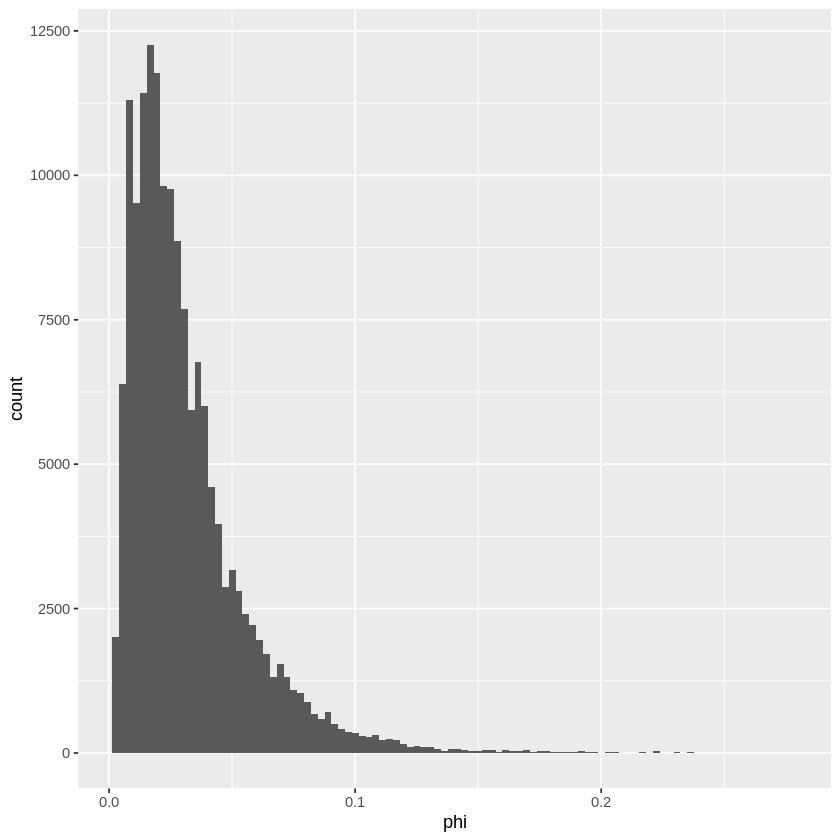

In [205]:
#2 Distribution
#ggplot(proxdf, aes(x = phi)) +
#  geom_histogram(bins = 100)

#summary(proxydf)

proxydf_unfiltered <- proxdf
proxydf <-  proxdf %>% filter(phi > 0.19) 
ggplot(proxdf, aes(x = phi)) +
  geom_histogram(bins = 100)

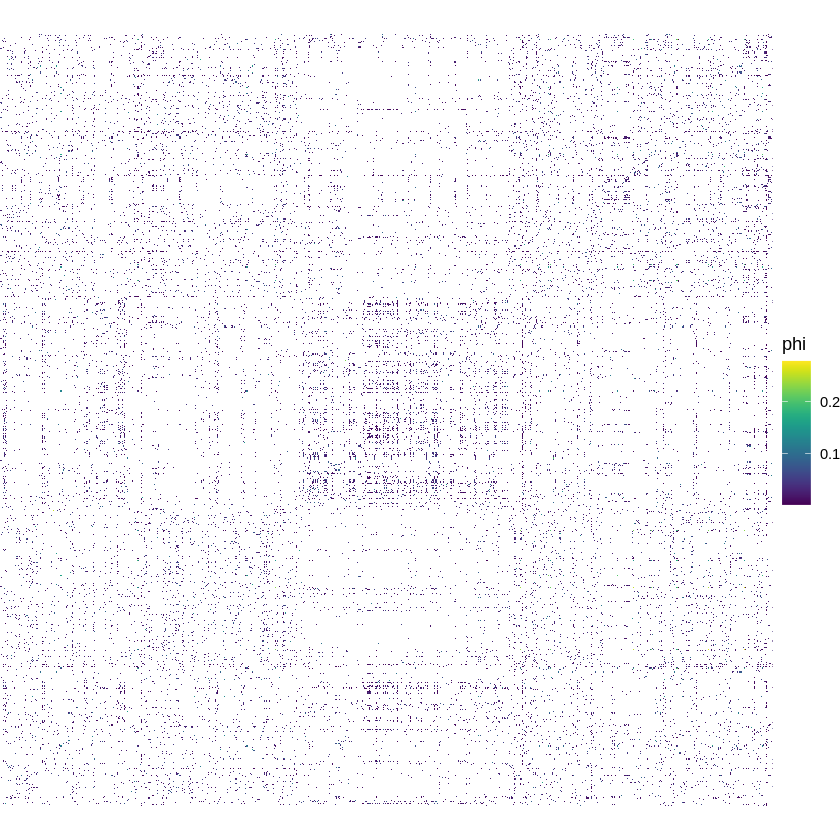

In [206]:


ggplot(proxdf, aes(task_col_1, task_col_2, fill = phi)) +
  geom_raster() +
  coord_equal() +
  scale_fill_viridis() +
  theme_void()

## Create graph and extract the backbone

1. Create a fullgraph: Given the proximity dataframe, we could convert them into network object
in igraph using the node dataframe and proximity/edge dataframe. By
default, it will create an undirected network

2. Maximum spanning tree of the full proximity-weighted graph provides the
basic skeleton that makes sure every nodes are connected.`igraph`
provides the function to generate the minimum spanning tree for
distance-weighted graph, let's use 1-proximity as the distance to
reverse the order and get the skeleton.

3. The next step is to add the more informative high-proximity edges to the
mst skeleton. Here it usually need some iterative tweaking of the
threshold, so we create a copy of the mst skeleton.

The 2007 paper used a threshold 0.55 for the inclusion of proximity
values, and this threshold seems reasonable on the distribution plot.
The following code generates the high proximity subgraph, and unions the
mst.

4. The new network seems quite sparse and we should be able to get a
meaningful representation rather than the hairball.



In [207]:
# use nodedf when task is converted to taskId
nodedf <- dwa_titles  %>%
  arrange(DWA_ID)
#  filter(hs_product_code %in% proxdf$commoditycode_1) %>%
#  select(hs_product_code, hs_product_name_short_en) %>%
#  arrange(hs_product_code)

# Since this is complete, We just use task_col_1
#nodedf <- proxdf %>%
#  select(task_col_1) %>%
#  distinct(task_col_1) %>%
#  mutate(task_col_name = task_col_1)

# head(nodedf)
# 1. Create a fullgraph
fullgraph <- graph_from_data_frame(proxdf, directed = FALSE, vertices = nodedf) %>%
  simplify(remove.multiple = TRUE, remove.loops = TRUE, edge.attr.comb = "first")
fullgraph

IGRAPH 0aedfee UN-- 2081 79636 -- 
+ attr: name (v/c), DWA_Title (v/c), phi (e/n)
+ edges from 0aedfee (vertex names):
 [1] 4.A.1.a.1.I01.D01--4.A.1.a.1.I01.D03 4.A.1.a.1.I01.D01--4.A.1.a.1.I17.D02
 [3] 4.A.1.a.1.I01.D01--4.A.1.a.1.I20.D08 4.A.1.a.1.I01.D01--4.A.1.a.2.I02.D03
 [5] 4.A.1.a.1.I01.D01--4.A.2.a.1.I05.D03 4.A.1.a.1.I01.D01--4.A.2.b.1.I04.D13
 [7] 4.A.1.a.1.I01.D01--4.A.2.b.1.I10.D03 4.A.1.a.1.I01.D01--4.A.2.b.2.I18.D02
 [9] 4.A.1.a.1.I01.D01--4.A.2.b.2.I18.D09 4.A.1.a.1.I01.D01--4.A.2.b.2.I18.D12
[11] 4.A.1.a.1.I01.D01--4.A.2.b.2.I18.D15 4.A.1.a.1.I01.D01--4.A.2.b.2.I18.D17
[13] 4.A.1.a.1.I01.D01--4.A.2.b.2.I25.D02 4.A.1.a.1.I01.D01--4.A.2.b.2.I25.D05
[15] 4.A.1.a.1.I01.D01--4.A.3.a.1.I08.D02 4.A.1.a.1.I01.D01--4.A.3.a.1.I10.D05
+ ... omitted several edges

In [208]:
# 2. Construct MST
gmst <- fullgraph %>% mst(weights = 1 - E(fullgraph)$phi, algorithm = "prim")
gmst

IGRAPH 880afe3 UN-- 2081 2080 -- 
+ attr: name (v/c), DWA_Title (v/c), phi (e/n)
+ edges from 880afe3 (vertex names):
 [1] 4.A.1.a.1.I01.D01--4.A.1.a.1.I20.D08 4.A.1.a.1.I01.D02--4.A.2.b.2.I25.D01
 [3] 4.A.1.a.1.I01.D02--4.A.4.b.4.I03.D03 4.A.1.a.1.I01.D03--4.A.4.b.4.I09.D01
 [5] 4.A.1.a.1.I01.D04--4.A.4.a.2.I09.D05 4.A.1.a.1.I01.D04--4.A.4.a.8.I01.D04
 [7] 4.A.1.a.1.I02.D01--4.A.4.b.4.I12.D14 4.A.1.a.1.I02.D02--4.A.2.b.1.I04.D12
 [9] 4.A.1.a.1.I02.D02--4.A.3.a.4.I01.D04 4.A.1.a.1.I02.D03--4.A.3.b.6.I08.D01
[11] 4.A.1.a.1.I02.D03--4.A.4.a.5.I09.D06 4.A.1.a.1.I02.D04--4.A.1.a.1.I02.D11
[13] 4.A.1.a.1.I02.D04--4.A.3.a.2.I41.D04 4.A.1.a.1.I02.D05--4.A.1.b.3.I01.D06
[15] 4.A.1.a.1.I02.D05--4.A.3.a.2.I04.D14 4.A.1.a.1.I02.D05--4.A.3.b.4.I03.D03
+ ... omitted several edges

In [209]:
# 3. Create a viz graph
vizgraph <- fullgraph %>% subgraph.edges(eids = E(fullgraph)[E(fullgraph)$phi > 0.2])
vizgraph <- gmst + vizgraph
E(vizgraph)$weight <- rowMeans(cbind(E(vizgraph)$phi_1, E(vizgraph)$phi_2), na.rm = TRUE)
vizgraph <- delete_edge_attr(vizgraph, "phi_1")
vizgraph <- delete_edge_attr(vizgraph, "phi_2")
vizgraph <- delete_vertex_attr(vizgraph, "task_col_name_2")
vizgraph

ERROR: ignored

In [210]:
# 4. Calculate Edge Density
edge_density(vizgraph)

[1] 0.0009924962

## Generate layout of the nodes

Before we jump to the visualization of full network, let's check how the
mst skeleton looks.

Here we use the Kamada-Kawai algorithm to generate a layout, which
generally works well for smaller networks:

```{r}
position <- layout_with_kk(gmst)
plot(gmst, layout = position, vertex.label = NA, vertex.size = 1)
```

The result already revealed some branches and clusters, we could use
this layout as an initial position and speed up the generation of
`vizgraph` layout.

In this step, you would probably want to explore different layout
algorithms, tune their parameters, and plot them until you get a
satisfying position. Sometimes, it may require some manual adjustments
before you finalize the layout.

The following use the initial position of the mst, and optimize the
layout of the whole network.

```{r}
position2 <- layout_with_kk(vizgraph, coords = position)
plot(vizgraph, layout = position2, vertex.label = NA, vertex.size = 1)
```

The position output is a matrix, we could create a dataframe and merge
it with the nodedf for future use.

```{r}
nodedf <- nodedf %>% mutate(x = position2[, 1], y = position2[, 2])
head(nodedf)
```

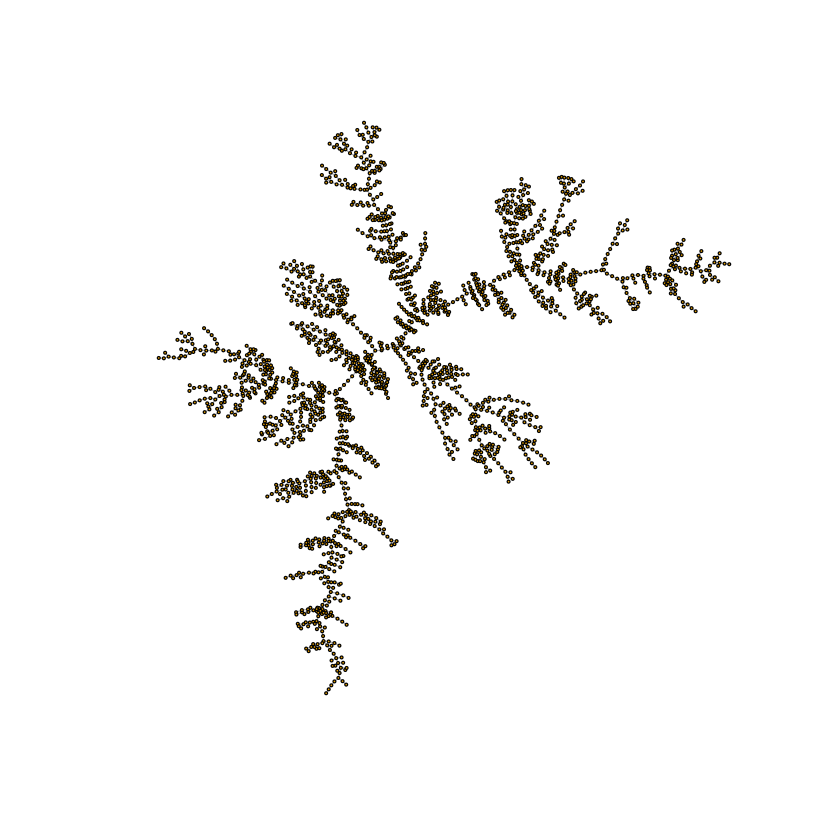

In [211]:
position <- layout_with_kk(gmst)
plot(gmst, layout = position, vertex.label = NA, vertex.size = 1)

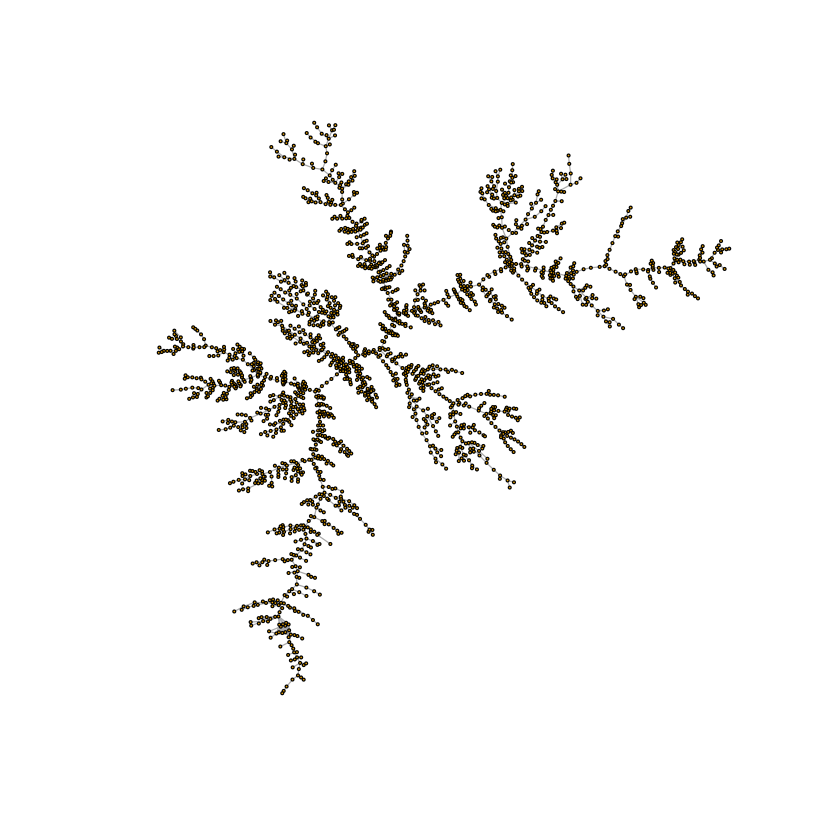

In [212]:
position2 <- layout_with_kk(vizgraph, coords = position)
plot(vizgraph, layout = position2, vertex.label = NA, vertex.size = 1)

In [213]:
nodedf <- nodedf %>% mutate(x = position2[, 1], y = position2[, 2])
head(nodedf)

,DWA_ID,DWA_Title,x,y
,<chr>,<chr>,<dbl>,<dbl>
1,4.A.1.a.1.I01.D01,Review art or design materials.,-3.766115,-0.4147357
2,4.A.1.a.1.I01.D02,Study details of musical compositions.,-2.508290,-2.8209249
3,4.A.1.a.1.I01.D03,Review production information to determine costume or makeup requirements.,2.123768,0.4478122
4,4.A.1.a.1.I01.D04,Study scripts to determine project requirements.,-2.928915,-2.0403645
5,4.A.1.a.1.I02.D01,Read materials to determine needed actions.,-5.089545,-18.8314967
6,4.A.1.a.1.I02.D02,Read maps to determine routes.,1.504023,-2.5463365


## Community detection

We would like to extract more meso-scale structural information out of
this network representation, one option is to extract the community
structure that reveal the block structure we saw in matrix plot.

There are a number of community detection algorithms. The Louvain
algorithm is one of the most widely used solution, and `igraph` has a
function `cluster_louvain` that implements the method.

```{r}
comm <- cluster_louvain(vizgraph)
length(comm)
```

We used the default parameter and get 41 communities.

The `comm` is a `communities` object. We could also add the id by
`membership` function to the nodedf dataframe for further analysis.

```{r}
nodedf <- nodedf %>% mutate(communityid = membership(comm))
head(nodedf)
```

The size of each community is via `sizes` function:

```{r}
sizes(comm)
```

For each community, we could check the included products to understand
its meaning.

For example, community 5 is a cluster of Shipping tasks

```{r}
nodedf %>%
  filter(communityid == 5) %>%
  sample_n(15)
```

Rearrange the rows and columns order, we see a clearer block structure
in the matrxi view heatmap

```{r}
orderbycomm <- (nodedf %>% arrange(communityid))$hs_product_code
ggplot(
  proxdf %>%
    mutate(
      commoditycode_1 = factor(commoditycode_1, levels = orderbycomm),
      commoditycode_2 = factor(commoditycode_2, levels = orderbycomm)
    ),
  aes(commoditycode_1, commoditycode_2, fill = proximity)
) +
  geom_raster() +
  coord_equal() +
  scale_fill_viridis() +
  theme_void()
```

In [214]:
comm <- cluster_louvain(vizgraph)
length(comm)

[1] 46

In [215]:
nodedf <- nodedf %>% mutate(communityid = membership(comm))
head(nodedf)

,DWA_ID,DWA_Title,x,y,communityid
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,4.A.1.a.1.I01.D01,Review art or design materials.,-3.766115,-0.4147357,1
2,4.A.1.a.1.I01.D02,Study details of musical compositions.,-2.508290,-2.8209249,2
3,4.A.1.a.1.I01.D03,Review production information to determine costume or makeup requirements.,2.123768,0.4478122,3
4,4.A.1.a.1.I01.D04,Study scripts to determine project requirements.,-2.928915,-2.0403645,2
5,4.A.1.a.1.I02.D01,Read materials to determine needed actions.,-5.089545,-18.8314967,4
6,4.A.1.a.1.I02.D02,Read maps to determine routes.,1.504023,-2.5463365,5


In [216]:
sizes(comm)

Community sizes
 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
34 55 40 48 64 68 71 34 34 63 38 37 51 49 56 44 52 23 21 63 52 52 35 75 29 31 
27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 
26 31 60 58 50 41 32 50 43 54 46 46 37 43 47 44 39 51 33 31 

In [217]:
nodedf %>%
  filter(communityid == 5) %>%
  sample_n(15)

DWA_ID,DWA_Title,x,y,communityid
<chr>,<chr>,<dbl>,<dbl>,<membrshp>
4.A.3.a.3.I06.D04,Operate packing or other material processing equipment.,5.274670,-3.036279,5
4.A.3.a.2.I22.D10,Position material handling equipment.,4.010797,-3.001531,5
4.A.3.a.2.I02.D01,Collect samples for analysis or testing.,3.611057,-4.176812,5
4.A.4.a.2.I08.D07,"Notify others of emergencies, problems, or hazards.",4.020193,-4.066292,5
4.A.3.b.4.I08.D02,Maintain vehicles in good working condition.,2.331924,-3.004481,5
4.A.4.b.4.I12.D21,Direct maintenance or repair activities.,3.112033,-3.936386,5
4.A.1.b.2.I05.D06,Monitor cargo area conditions.,4.382684,-4.534984,5
4.A.4.a.2.I03.D19,Receive information or instructions for performing work assignments.,2.825197,-3.017265,5
4.A.1.b.3.I01.D14,Weigh materials to ensure compliance with specifications.,3.163289,-3.299169,5


In [218]:
proxdf %>% head(N=10)
nodedf %>% head(N=10)
# lets extract Other Work characteristics from DWA 
# Detailed Work Activity(2087 Unique Values), Eg. 4.A.1.a.1.I01.D01
# Industry Work Activity (332 Unique Values), Eg. 4.A.1.a.1.I01
# Work Activity (37 Unique Values), Eg. 4.A.1.a.1

#iwa_list <- substring(proxydf$task_col_1, 1,13)
#iwa_list %>% head(N=10)

task_col_1,task_col_2,phi
<chr>,<chr>,<dbl>
4.A.1.a.1.I01.D01,4.A.1.a.1.I01.D03,0.042229730
4.A.1.a.1.I01.D01,4.A.1.a.1.I17.D02,0.042229730
4.A.1.a.1.I01.D01,4.A.1.a.1.I20.D08,0.126689189
4.A.1.a.1.I01.D01,4.A.1.a.2.I02.D03,0.019623234
4.A.1.a.1.I01.D01,4.A.2.a.1.I05.D03,0.008721437
4.A.1.a.1.I01.D01,4.A.2.b.1.I04.D13,0.035631570


,DWA_ID,DWA_Title,x,y,communityid
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,4.A.1.a.1.I01.D01,Review art or design materials.,-3.766115,-0.4147357,1
2,4.A.1.a.1.I01.D02,Study details of musical compositions.,-2.508290,-2.8209249,2
3,4.A.1.a.1.I01.D03,Review production information to determine costume or makeup requirements.,2.123768,0.4478122,3
4,4.A.1.a.1.I01.D04,Study scripts to determine project requirements.,-2.928915,-2.0403645,2
5,4.A.1.a.1.I02.D01,Read materials to determine needed actions.,-5.089545,-18.8314967,4
6,4.A.1.a.1.I02.D02,Read maps to determine routes.,1.504023,-2.5463365,5


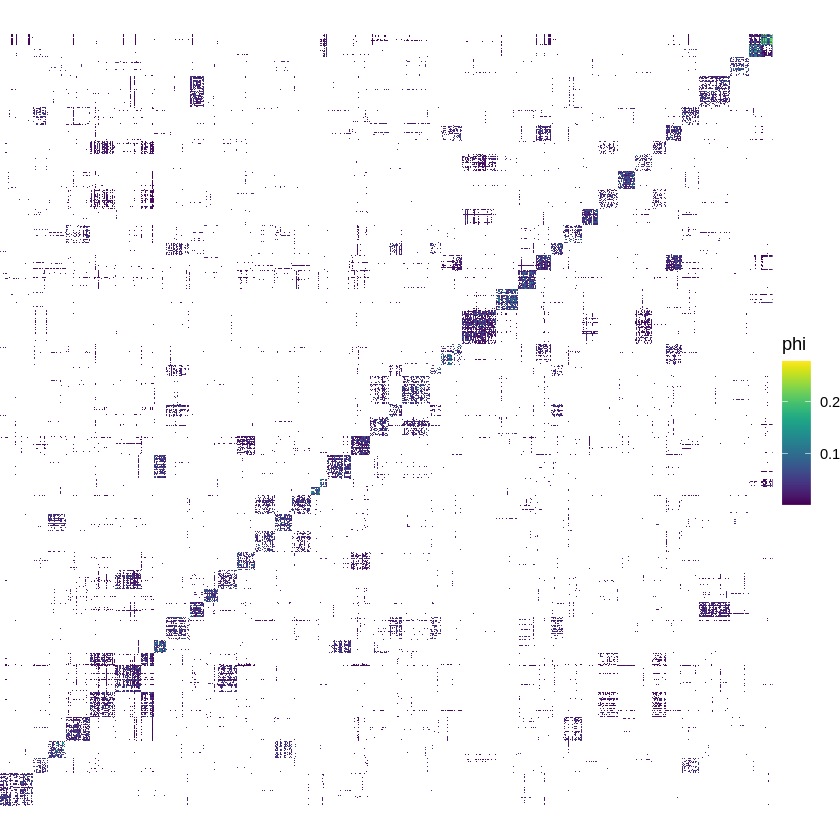

In [219]:
#ggplot(proxdf, aes(task_col_1, task_col_2, fill = phi)) +
#  geom_raster() +
#  coord_equal() +
#  scale_fill_viridis() +
#  theme_void()

orderbycomm <- (nodedf %>% arrange(communityid))$DWA_ID
ggplot(
  proxdf %>%
    mutate(
      task_col_1 = factor(task_col_1, levels = orderbycomm),
      task_col_2 = factor(task_col_2, levels = orderbycomm)
    ),
  aes(task_col_1, task_col_2, fill = phi)
) +
  geom_raster() +
  coord_equal() +
  scale_fill_viridis() +
  theme_void()

## Mapping properties to aesthetic elements

Once we have fixed the position of nodes in the network, the aesthetic
elements we could use are mainly the color and size of the nodes.
Different shapes of the nodes are not very distinguishable with \>1000
nodes, and labels are only usable to annotate few
nodes/sectors/communities.

In this section, we will use a saved output from the atlas of economic
complexity for 2015. You could create these files by following previousl tutorials,
or running the `economiccomplexity` package and collect outputs.

In [220]:
#if (!file.exists("df_ec.tsv")) {
#  download.file("https://www.dropbox.com/s/510nkpc7mwnjvbp/df_ec.tsv?dl=1", "df_ec.tsv")
#}
#df_ec <- read_tsv("df_ec.tsv")
#head(df_ec)

### use ggraph

The aesthetic mapping could be done by manually creating vectors of color/shape/etc.
as the input of `igrpah` plotting function. However, the more elegant and "tidy"
flavor of graph ploting is to leverage the ability of `ggplot2` as a backend to do
these mapping automatically. `ggraph` is a package that bridges the `ggplot2` system
and graph object. There are other alternatives such as `ggnetwork` and `ggnet2`, but
we will stick to the `ggraph` package hear for its rich features.

The following codes converts the `vizgraph` object into the `tbl_graph` object

```{r}
vizgg <- vizgraph %>% as_tbl_graph()
vizgg
```
 
You can see the object is actually two dataframes that could be altered with tidy verbs. The following
shows how to left join our generated community id to this object:

```{r}
vizgg <- vizgg %>%
  activate(nodes) %>%
  left_join(nodedf %>% select(hs_product_code, communityid), by = c("name" = "hs_product_code"))
vizgg
```

Let's use `ggplot2` style to plot this object with our generated layout `position2`,
tune the theme:

```{r}
vizgg %>% ggraph(layout = position2) +
  geom_edge_link(color = "grey") +
  geom_node_point(color = "blue") +
  theme_void()
```

In [221]:
vizgg <- vizgraph %>% as_tbl_graph()
vizgg

# A tbl_graph: 2081 nodes and 2148 edges
#
# An undirected simple graph with 1 component
#
# Node Data: 2,081 × 3 (active)
  DWA_Title_1                                           DWA_Title_2 name        
  <chr>                                                 <chr>       <chr>       
1 Review art or design materials.                       NA          4.A.1.a.1.I…
2 Study details of musical compositions.                NA          4.A.1.a.1.I…
3 Review production information to determine costume o… NA          4.A.1.a.1.I…
4 Study scripts to determine project requirements.      NA          4.A.1.a.1.I…
5 Read materials to determine needed actions.           NA          4.A.1.a.1.I…
6 Read maps to determine routes.                        NA          4.A.1.a.1.I…
# … with 2,075 more rows
#
# Edge Data: 2,148 × 3
   from    to weight
  <int> <int>  <dbl>
1  2053  2075 0.113 
2  2053  2073 0.104 
3  2051  2066 0.0588
# … with 2,145 more rows

In [222]:
vizgg <- vizgg %>%
  activate(nodes) %>%
  left_join(nodedf %>% select(DWA_ID, communityid), by = c("name" = "DWA_ID"))
vizgg

# A tbl_graph: 2081 nodes and 2148 edges
#
# An undirected simple graph with 1 component
#
# Node Data: 2,081 × 4 (active)
  DWA_Title_1                                 DWA_Title_2 name       communityid
  <chr>                                       <chr>       <chr>      <membrshp> 
1 Review art or design materials.             NA          4.A.1.a.1… 1          
2 Study details of musical compositions.      NA          4.A.1.a.1… 2          
3 Review production information to determine… NA          4.A.1.a.1… 3          
4 Study scripts to determine project require… NA          4.A.1.a.1… 2          
5 Read materials to determine needed actions. NA          4.A.1.a.1… 4          
6 Read maps to determine routes.              NA          4.A.1.a.1… 5          
# … with 2,075 more rows
#
# Edge Data: 2,148 × 3
   from    to weight
  <int> <int>  <dbl>
1  2053  2075 0.113 
2  2053  2073 0.104 
3  2051  2066 0.0588
# … with 2,145 more rows

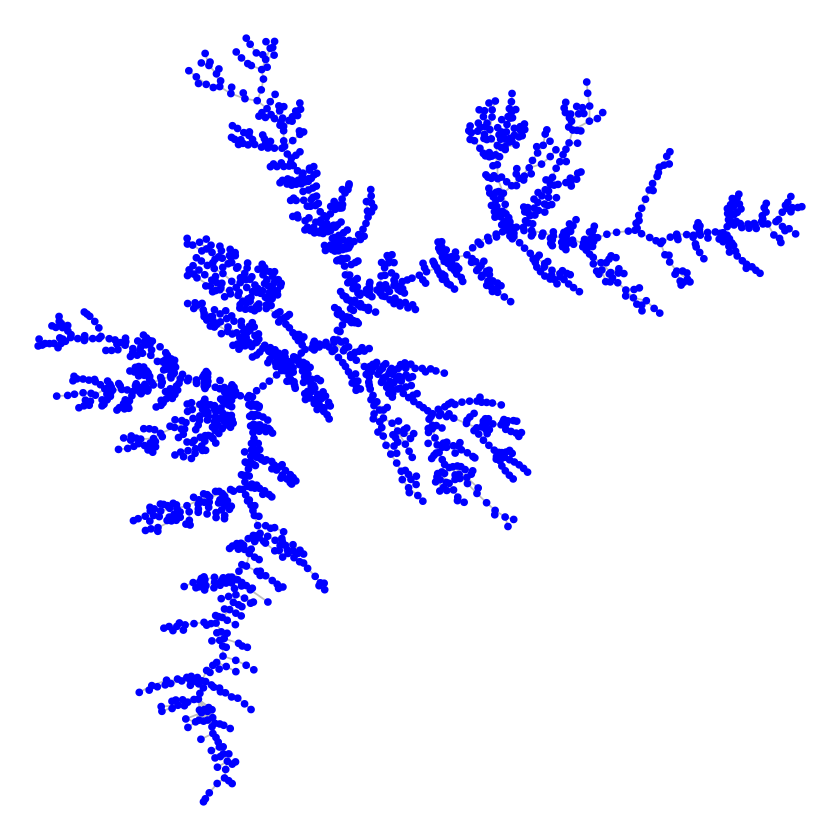

In [223]:
vizgg %>% ggraph(layout = position2) +
  geom_edge_link(color = "grey") +
  geom_node_point(color = "blue") +
  theme_void()

### Color

The color of the nodes are usually used to indicate different
categories, such as 2-digit sectors or the communities we discovered
above.

A meaningful color map usually require some manual design, such as using
brown to represent mining activities and products. Here we would just
assign a color to each community without further improvement.

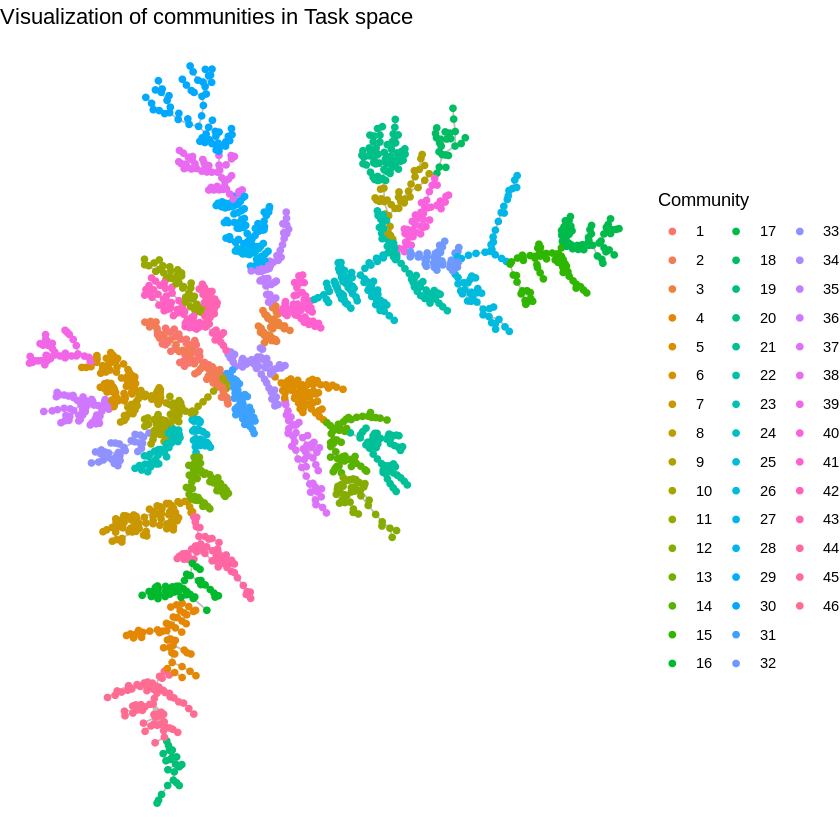

In [224]:
vizgg %>% ggraph(layout = position2) +
  geom_edge_link(color = "grey") +
  geom_node_point(aes(color = factor(communityid))) +
  theme_void() +
  guides(color = guide_legend(title = "Community")) +
  ggtitle("Visualization of communities in Task space")

### Size

We will use the node size to represent the PCI of each product, let's
extract the PCI and join the graph object:

Here we specify the size should be mapped to pci, and the `scale_*` function could
be used to tune details. Let's save the object as `p` for further use


In [225]:
df_pci %>% head(10)
#vizgg %>% head(10)

pci,product,product_code
<dbl>,<chr>,<chr>
-1.3653618,4.A.1.a.1.I01.D01,Review art or design materials.
-1.5836438,4.A.1.a.1.I01.D02,Study details of musical compositions.
-0.2971447,4.A.1.a.1.I01.D03,Review production information to determine costume or makeup requirements.
-1.5151754,4.A.1.a.1.I01.D04,Study scripts to determine project requirements.
-0.2456178,4.A.1.a.1.I02.D01,Read materials to determine needed actions.
-0.4321181,4.A.1.a.1.I02.D02,Read maps to determine routes.
-0.4021239,4.A.1.a.1.I02.D03,Review customer information.
0.9117264,4.A.1.a.1.I02.D04,Read work orders or other instructions to determine product specifications or materials requirements.
0.7358674,4.A.1.a.1.I02.D05,Read technical information needed to perform maintenance or repairs.


In [226]:
vizgg <- vizgg %>%
  activate(nodes) %>%
  left_join(df_pci %>% select("product", "pci") %>% distinct(), by = c("name" = "product"))
vizgg

# A tbl_graph: 2081 nodes and 2148 edges
#
# An undirected simple graph with 1 component
#
# Node Data: 2,081 × 5 (active)
  DWA_Title_1                           DWA_Title_2 name      communityid    pci
  <chr>                                 <chr>       <chr>     <membrshp>   <dbl>
1 Review art or design materials.       NA          4.A.1.a.… 1           -1.37 
2 Study details of musical composition… NA          4.A.1.a.… 2           -1.58 
3 Review production information to det… NA          4.A.1.a.… 3           -0.297
4 Study scripts to determine project r… NA          4.A.1.a.… 2           -1.52 
5 Read materials to determine needed a… NA          4.A.1.a.… 4           -0.246
6 Read maps to determine routes.        NA          4.A.1.a.… 5           -0.432
# … with 2,075 more rows
#
# Edge Data: 2,148 × 3
   from    to weight
  <int> <int>  <dbl>
1  2053  2075 0.113 
2  2053  2073 0.104 
3  2051  2066 0.0588
# … with 2,145 more rows

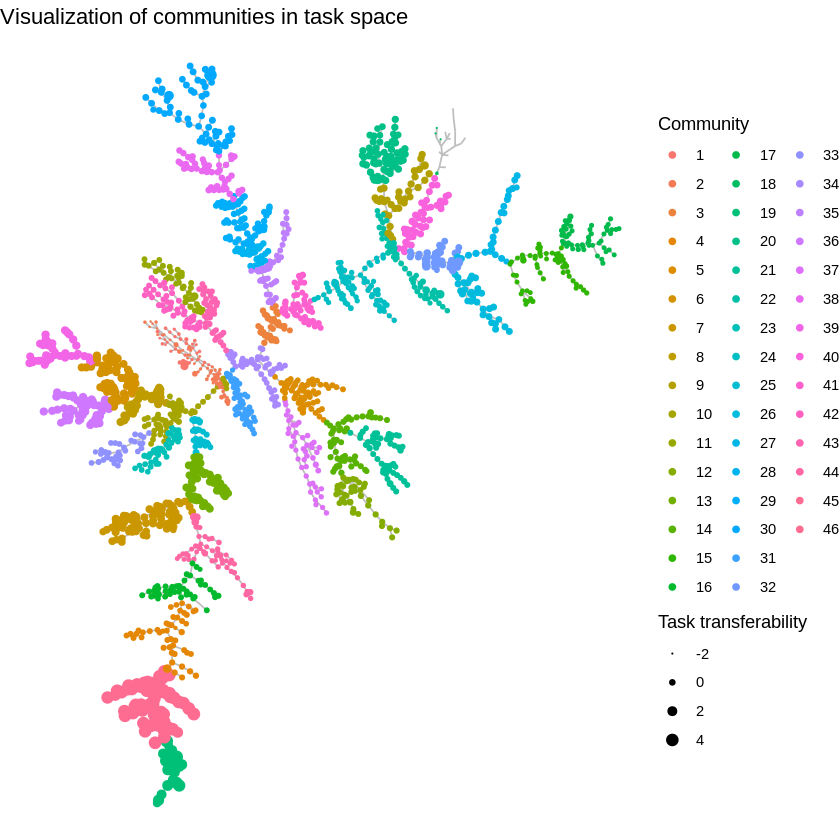

In [227]:
p <- vizgg %>% ggraph(layout = position2) +
  geom_edge_link(color = "grey") +
  geom_node_point(aes(color = factor(communityid), size = pci)) +
  scale_size(range = c(-2, 3)) + #scale_size(range = c(0.1, 3)) +
  theme_void() +
  guides(color = guide_legend(title = "Community"), size = guide_legend(title = "Task transferability"))
p + ggtitle("Visualization of communities in task space")


### Annotation

Sometimes we would like to add some annotations to the product space
visualization. Here we will first calculate the center of each community:

Add the communityid to the center with `geom_text`. You could also annotate nodes based on your needs.

In [228]:
df_anno <- nodedf %>%
  group_by(communityid) %>%
  summarise(x = mean(x), y = mean(y))
head(df_anno)

communityid,x,y
<membrshp>,<dbl>,<dbl>
1,-4.630580,-0.8055319
2,-3.392895,-1.9447099
3,1.291798,0.4285827
4,-5.366032,-17.7528092
5,3.425594,-3.5143967
6,-8.935514,-2.6932915


Don't know how to automatically pick scale for object of type membership. Defaulting to continuous.



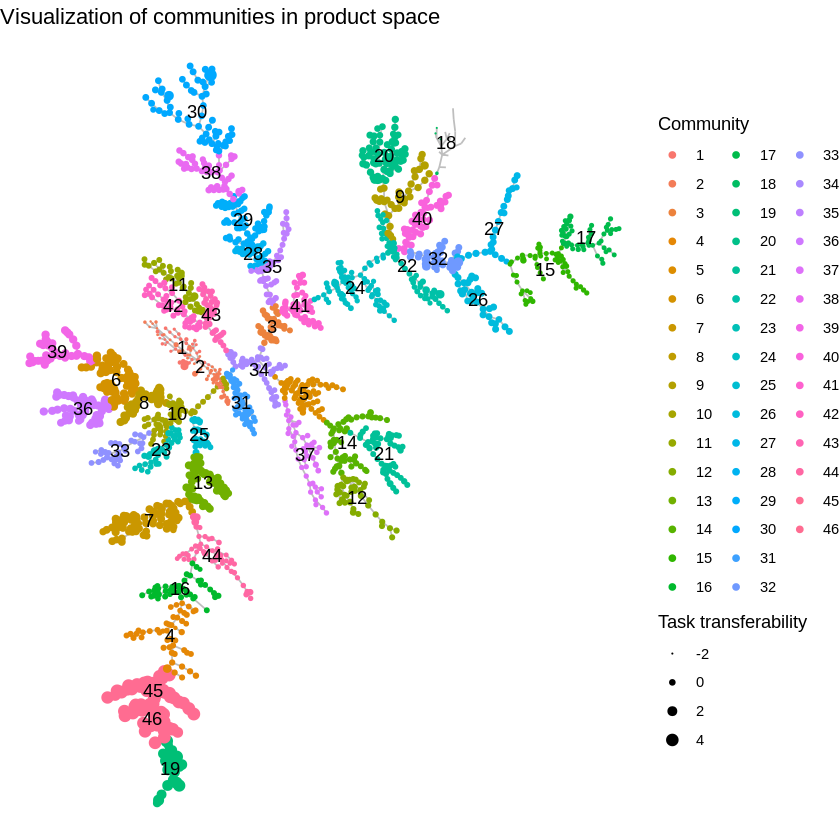

In [229]:
p + geom_text(data = df_anno, aes(x, y, label = communityid)) +
  ggtitle("Visualization of communities in product space")

### Job specific plot

With the full task space, we can highlight the task with Importance 
_________
RCA>1
for a region. The following shows products of Chief Executives in 2015.

Join the dataset with graph object

We could set the background layer as grey, and the node color that Japan doesn't
have comparative advantage has alpha=0.

The visualization could be further improved with any `ggplot2` style tricks.

In [230]:
# Chief Executives
# 11-1011.00	Chief Executives
df_rca %>% head(3)
dwa_titles %>% head(3)

# TODO: Fix df_rca for ducplicate values, Also use manual Mcp = (0,1)

dim(df_rca)


dim(dwa_titles)
df_ceo <- df_rca %>%
  filter(job_col == "11-1011.00") %>%  #  11-1011.00	Chief Executives
  rename(DWA_ID = task_col)  %>%
  select(DWA_ID, Mcp)


df_ceo_avg <-
    df_ceo %>% 
      group_by(DWA_ID) %>%
      summarise(across(, mean, na.rm = TRUE))
#    task_rating_dwa_avg
dim(df_ceo_avg) 

node_list <-
  vizgg %>%
  activate(nodes) %>%
  data.frame()
dim(node_list)

df_ceo %>% head(3)
dim(df_ceo)
df_ceo_all <- merge(dwa_titles, df_ceo_avg, by=c("DWA_ID"), all = TRUE)
#df_ceo_all %>% filter(!is.na(Mcp))
dim(df_ceo_all)
df_ceo_all_impTask <- 
  df_ceo_all  %>%
  mutate(Important = as.integer(Mcp > 0)) 

merge(df_ceo_all_impTask %>% filter(Important ==1), df_pci %>% rename(DWA_ID = product), by="DWA_ID")
#df_ceo_all_impTask %>% 
#  filter(Important ==1)
#df_pci %>% head(10)

#df_ceo_all = merge(task_titles, df_ceo, %>%
#  merge()
#vizgg$nodes


,job_col,task_col,value_col,product_code,Mcp
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,11-1011.00,4.A.4.b.6.I08.D04,3.64,4.A.4.b.6.I08.D04,3.64
2,11-1011.00,4.A.2.a.4.I09.D03,3.64,4.A.2.a.4.I09.D03,3.64
3,11-1011.00,4.A.4.b.4.I09.D02,4.54,4.A.4.b.4.I09.D02,4.54


,DWA_ID,DWA_Title
,<chr>,<chr>
1,4.A.4.b.6.I08.D04,Advise others on legal or regulatory compliance matters.
2,4.A.2.a.4.I09.D03,Analyze impact of legal or regulatory changes.
19,4.A.4.b.4.I09.D02,Direct financial operations.


[1] 21783     5

[1] 2081    2

[1] 27  2

[1] 2081    5

,DWA_ID,Mcp
,<chr>,<dbl>
1,4.A.4.b.6.I08.D04,3.64
2,4.A.2.a.4.I09.D03,3.64
3,4.A.4.b.4.I09.D02,4.54


[1] 33  2

[1] 2081    3

DWA_ID,DWA_Title,Mcp,Important,pci,product_code
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4.A.2.a.4.I07.D09,Analyze data to assess operational or project effectiveness.,4.400000,1,0.22489239,Analyze data to assess operational or project effectiveness.
4.A.2.a.4.I07.D12,Analyze data to inform operational decisions or activities.,3.820000,1,0.27019008,Analyze data to inform operational decisions or activities.
4.A.2.a.4.I09.D03,Analyze impact of legal or regulatory changes.,3.640000,1,-0.02953441,Analyze impact of legal or regulatory changes.
4.A.2.b.1.I09.D01,Implement organizational process or policy changes.,4.390000,1,0.23069850,Implement organizational process or policy changes.
4.A.2.b.4.I01.D01,Develop organizational policies or programs.,4.390000,1,0.18535348,Develop organizational policies or programs.
4.A.2.b.4.I02.D01,Draft legislation or regulations.,3.630000,1,-1.40298643,Draft legislation or regulations.
4.A.3.b.6.I01.D02,"Prepare financial documents, reports, or budgets.",3.650000,1,-0.22206985,"Prepare financial documents, reports, or budgets."
4.A.3.b.6.I15.D06,Prepare operational progress or status reports.,3.650000,1,0.24725788,Prepare operational progress or status reports.
4.A.4.a.1.I02.D03,Communicate organizational policies and procedures.,3.690000,1,0.23145058,Communicate organizational policies and procedures.


In [231]:
#vizgg <- vizgg %>%
#  activate(nodes) %>%
#  left_join(df_pci %>% select("product", "pci") %>% distinct(), by = c("name" = "product"))
#vizgg


viz_ceo <- vizgg %>%
  activate(nodes) %>%
  left_join(df_ceo_all_impTask, by = c("name" = "DWA_ID"))
viz_ceo

# A tbl_graph: 2081 nodes and 2148 edges
#
# An undirected simple graph with 1 component
#
# Node Data: 2,081 × 8 (active)
  DWA_Title_1   DWA_Title_2 name   communityid    pci DWA_Title    Mcp Important
  <chr>         <chr>       <chr>  <membrshp>   <dbl> <chr>      <dbl>     <int>
1 Review art o… NA          4.A.1… 1           -1.37  Review ar…    NA        NA
2 Study detail… NA          4.A.1… 2           -1.58  Study det…    NA        NA
3 Review produ… NA          4.A.1… 3           -0.297 Review pr…    NA        NA
4 Study script… NA          4.A.1… 2           -1.52  Study scr…    NA        NA
5 Read materia… NA          4.A.1… 4           -0.246 Read mate…    NA        NA
6 Read maps to… NA          4.A.1… 5           -0.432 Read maps…    NA        NA
# … with 2,075 more rows
#
# Edge Data: 2,148 × 3
   from    to weight
  <int> <int>  <dbl>
1  2053  2075 0.113 
2  2053  2073 0.104 
3  2051  2066 0.0588
# … with 2,145 more rows

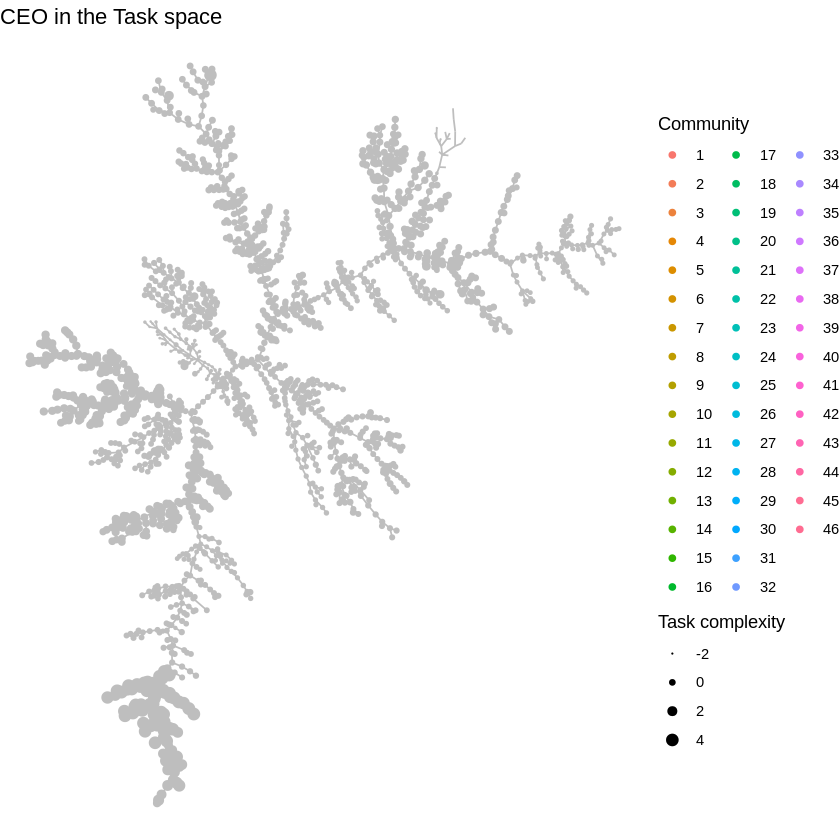

In [232]:
viz_ceo %>% ggraph(layout = position2) +
  geom_edge_link(color = "grey") +
  geom_node_point(aes(size = pci), color = "grey") +
  geom_node_point(aes(color = factor(communityid), size = pci, alpha = factor(Important))) +
  scale_size(range = c(-2, 3)) +
  scale_alpha_manual(values = c(0, 1), na.value = 0, guide = "none") +
  theme_void() +
  guides(color = guide_legend(title = "Community"), size = guide_legend(title = "Task complexity")) +
  ggtitle("CEO in the Task space")

## Save the result for future use

After a series of operations, we finalized the visualization. It's
better to save them and prevent repeating the same process.

To save the plotting results, just use `ggsave`:

Besides the visualization, you may also want to save the networks and
node attributes dataframe, which helps you resume the analysis, or
conduct analysis in other softwares. For example, save network into
graphml format, and you could load it in Gephi for powerful plots.

In [233]:
ggsave("productspace.png", p)
vizgraph %>% write_graph("productspace.graphml", format = "graphml")

Saving 6.67 x 6.67 in image



## Why do we need the edges?

As you may have noticed, in the network visualization above, we specify the edges to be grey
and did nothing else. Most of the manipulations are for the layout of nodes, the color and size
of nodes, the alpha of nodes, etc.

If we ignore all the edges, and purely rely on the `nodedf`, we can still get reasonable plots as:

In [234]:
df_pci %>% head(3)
nodedf %>% head(3)

pci,product,product_code
<dbl>,<chr>,<chr>
-1.3653618,4.A.1.a.1.I01.D01,Review art or design materials.
-1.5836438,4.A.1.a.1.I01.D02,Study details of musical compositions.
-0.2971447,4.A.1.a.1.I01.D03,Review production information to determine costume or makeup requirements.


,DWA_ID,DWA_Title,x,y,communityid
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,4.A.1.a.1.I01.D01,Review art or design materials.,-3.766115,-0.4147357,1
2,4.A.1.a.1.I01.D02,Study details of musical compositions.,-2.508290,-2.8209249,2
3,4.A.1.a.1.I01.D03,Review production information to determine costume or makeup requirements.,2.123768,0.4478122,3


Joining, by = "DWA_ID"


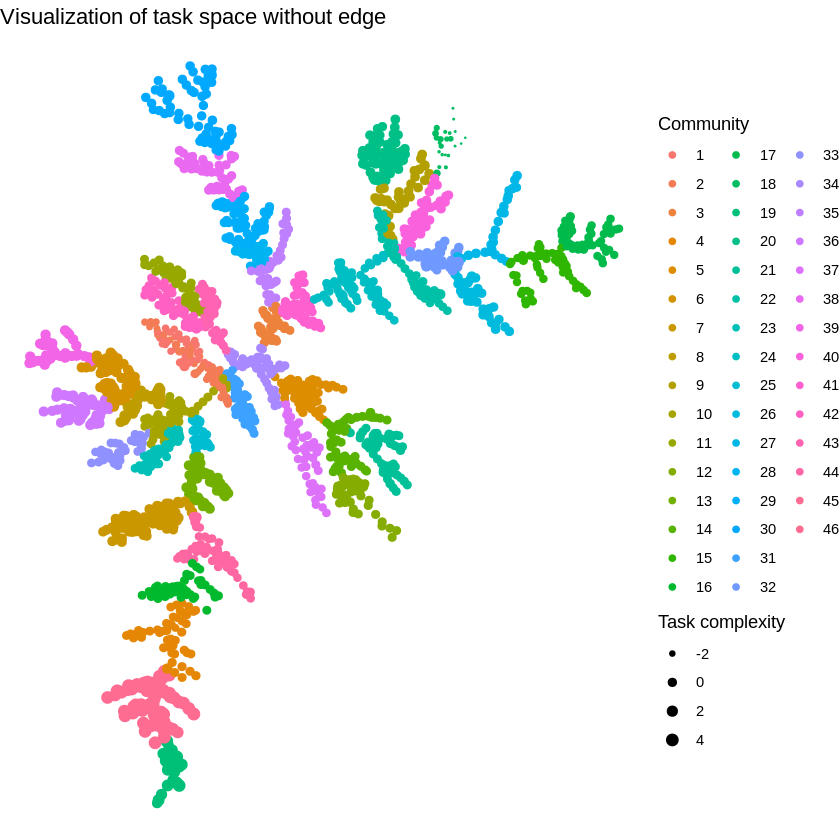

In [235]:
df_pci_dwa <- df_pci %>% rename(DWA_ID = product)


nodedf <- nodedf %>%
  left_join(df_pci_dwa %>% select("DWA_ID", "pci") %>% distinct())
nodedf %>%
  ggplot(aes(x, y, color = factor(communityid), size = pci)) +
  geom_point() +
  scale_size(range = c(0.1, 3)) +
  theme_void() +
  guides(color = guide_legend(title = "Community"), size = guide_legend(title = "Task complexity")) +
  ggtitle("Visualization of task space without edge")

### UMAP visualization



We will follow the above idea and use the umap to generate the "layout" and do the visualization.
The UMAP is already used in the [Metroverse](https://metroverse.cid.harvard.edu/) for the visualization of industry space

UMAP could calculate the distance metric from the raw data, or use the supplied distance matrix.
Here we just use the same proximity matrix, and convert to a distance matrix:

```{r}
proxmat <- fullgraph %>% as_adj(attr = "proximity")
distmat <- as.matrix(1 - proxmat)
diag(distmat) <- 0
dim(distmat)
```

Use 5 nearest neighbors, and specify our input is a distance matrix to generate the UMAP embedding:

```{r}
umapres <- umap(distmat, input = "dist", n_neighbors = 5)
```

Extract the embedding/layout into the nodedf matrix:

```{r}
nodedf <- nodedf %>%
  mutate(umap_x = umapres$layout[, 1], umap_y = umapres$layout[, 2])
head(nodedf)
```

Generate visualization with the UMAP layout:

```{r}
nodedf %>%
  ggplot(aes(umap_x, umap_y, color = factor(communityid), size = pci)) +
  geom_point() +
  scale_size(range = c(0.1, 3)) +
  theme_void() +
  guides(color = guide_legend(title = "Community"), size = guide_legend(title = "Product complexity")) +
  ggtitle("Visualization of product space with UMAP")
```

The communities extracted from network method still have interpretable meaning with the UMAP.
However, you could use various clustering tools now to generate different group divisions.
A good choice would be some density based clustering method such as dbscan/hdbsan.

In [236]:
proxmat <- fullgraph %>% as_adj(attr = "phi")
distmat <- as.matrix(1 - proxmat)
diag(distmat) <- 0
dim(distmat)

[1] 2081 2081

In [237]:
umapres <- umap(distmat, input = "dist", n_neighbors = 5)
nodedf <- nodedf %>%
  mutate(umap_x = umapres$layout[, 1], umap_y = umapres$layout[, 2])
head(nodedf)

,DWA_ID,DWA_Title,x,y,communityid,pci,umap_x,umap_y
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4.A.1.a.1.I01.D01,Review art or design materials.,-3.766115,-0.4147357,1,-1.3653618,-1.679677,-3.6371336
2,4.A.1.a.1.I01.D02,Study details of musical compositions.,-2.508290,-2.8209249,2,-1.5836438,-1.712013,-2.9663160
3,4.A.1.a.1.I01.D03,Review production information to determine costume or makeup requirements.,2.123768,0.4478122,3,-0.2971447,7.650227,0.5117341
4,4.A.1.a.1.I01.D04,Study scripts to determine project requirements.,-2.928915,-2.0403645,2,-1.5151754,-1.580909,-3.0630951
5,4.A.1.a.1.I02.D01,Read materials to determine needed actions.,-5.089545,-18.8314967,4,-0.2456178,1.093079,8.5646113
6,4.A.1.a.1.I02.D02,Read maps to determine routes.,1.504023,-2.5463365,5,-0.4321181,-6.611979,2.1377171


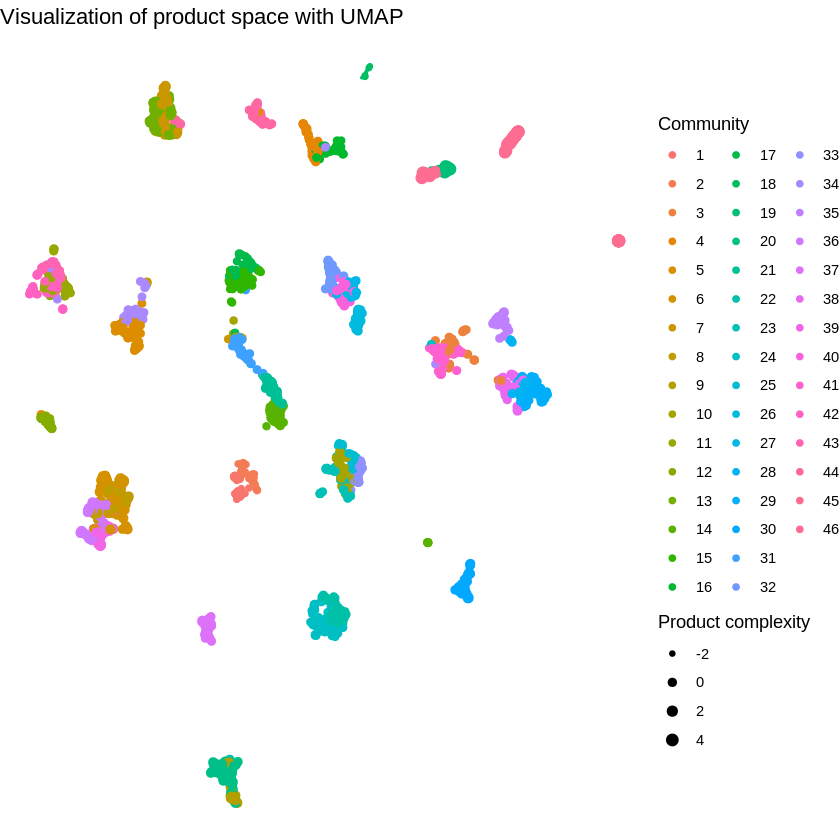

In [238]:
nodedf %>%
  ggplot(aes(umap_x, umap_y, color = factor(communityid), size = pci)) +
  geom_point() +
  scale_size(range = c(0.1, 3)) +
  theme_void() +
  guides(color = guide_legend(title = "Community"), size = guide_legend(title = "Product complexity")) +
  ggtitle("Visualization of product space with UMAP")

# 2. Other useful visualizations (Tree Map)

In this section, we will practice how to visualize with treemap 
which are both commonly used in economic complexity analysis. 
1. Install and load necessary packages:

2. Again, let's use CEO as an example, aggregate to 2 digits level:

3. Load product names and merge:

4. Use the `treemap` package to plot a nested treemap

In [241]:
package_list <-
  c(
    "tidyverse",
    "viridis",
    "sf",
    "treemap"
    #"rnaturalearth",
    #"rnaturalearthdata"
  )
# Check if packages are already installed, otherwise install them
to_install <-
  package_list[!(package_list %in% installed.packages()[, "Package"])]
if (length(to_install)) {
  install.packages(to_install)
}
library(tidyverse)
library(treemap)
library(viridis)
library(sf)
#library(rnaturalearth)
#library(rnaturalearthdata)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘sass’, ‘e1071’, ‘wk’, ‘httpuv’, ‘xtable’, ‘fontawesome’, ‘sourcetools’, ‘later’, ‘promises’, ‘bslib’, ‘classInt’, ‘s2’, ‘units’, ‘gridBase’, ‘shiny’


Warning message in install.packages(to_install):
“installation of package ‘units’ had non-zero exit status”
Warning message in install.packages(to_install):
“installation of package ‘sf’ had non-zero exit status”


ERROR: ignored

In [245]:
df_ceo_titles %>%  mutate(
    	Work_Activities_Element_ID	 = substring(DWA_ID,1,9))  %>% 
      head(3)
wa_ability %>%  head(3)

,DWA_ID,DWA_Title,Mcp,Important,pci,product_code,Work_Activities_Element_ID
,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>
1,4.A.2.a.4.I07.D09,Analyze data to assess operational or project effectiveness.,4.40,1,0.22489239,Analyze data to assess operational or project effectiveness.,4.A.2.a.4
2,4.A.2.a.4.I07.D12,Analyze data to inform operational decisions or activities.,3.82,1,0.27019008,Analyze data to inform operational decisions or activities.,4.A.2.a.4
3,4.A.2.a.4.I09.D03,Analyze impact of legal or regulatory changes.,3.64,1,-0.02953441,Analyze impact of legal or regulatory changes.,4.A.2.a.4


Work_Activities_Element_ID,Work_Activities_Element_Name,Abilities_Element_ID,Abilities_Element_Name
<chr>,<chr>,<chr>,<chr>
4.A.1.a.1,Getting Information,1.A.1.a.1,Oral Comprehension
4.A.1.a.2,"Monitoring Processes, Materials, or Surroundings",1.A.1.a.1,Oral Comprehension
4.A.1.b.1,"Identifying Objects, Actions, and Events",1.A.1.a.1,Oral Comprehension


In [261]:
# lets extract Other Work characteristics from DWA 
# Detailed Work Activity(2087 Unique Values), Eg. 4.A.1.a.1.I01.D01
# Industry Work Activity (332 Unique Values), Eg. 4.A.1.a.1.I01
# Work Activity (37 Unique Values), Eg. 4.A.1.a.1
#iwa_list <- substring(proxydf$task_col_1, 1,13)
#iwa_list %>% head(N=10)

df_ceo_titles <- merge(
        df_ceo_all_impTask %>% filter(Important ==1),
        df_pci %>% rename(DWA_ID = product),
        by="DWA_ID") %>%
    mutate(Work_Activities_Element_ID	 = substring(DWA_ID,1,9))

#dim(df_ceo_titles)

df_ceo_category <- merge(
      df_ceo_titles,
      wa_titles %>% rename(category = Work_Activities_Element_Name), 
      by = "Work_Activities_Element_ID")  %>%
  group_by(DWA_Title, category) %>%
  summarise(total_Imp = sum(Mcp))
dim(df_ceo_category)

head(df_ceo_category)


`summarise()` has grouped output by 'DWA_Title'. You can override using the
`.groups` argument.


[1] 27  3

DWA_Title,category,total_Imp
<chr>,<chr>,<dbl>
Advise others on legal or regulatory compliance matters.,Providing Consultation and Advice to Others,3.64
Analyze data to assess operational or project effectiveness.,Analyzing Data or Information,4.40
Analyze data to inform operational decisions or activities.,Analyzing Data or Information,3.82
Analyze impact of legal or regulatory changes.,Analyzing Data or Information,3.64
Communicate organizational policies and procedures.,Interpreting the Meaning of Information for Others,3.69
Confer with organizational members to accomplish work activities.,"Communicating with Supervisors, Peers, or Subordinates",4.15


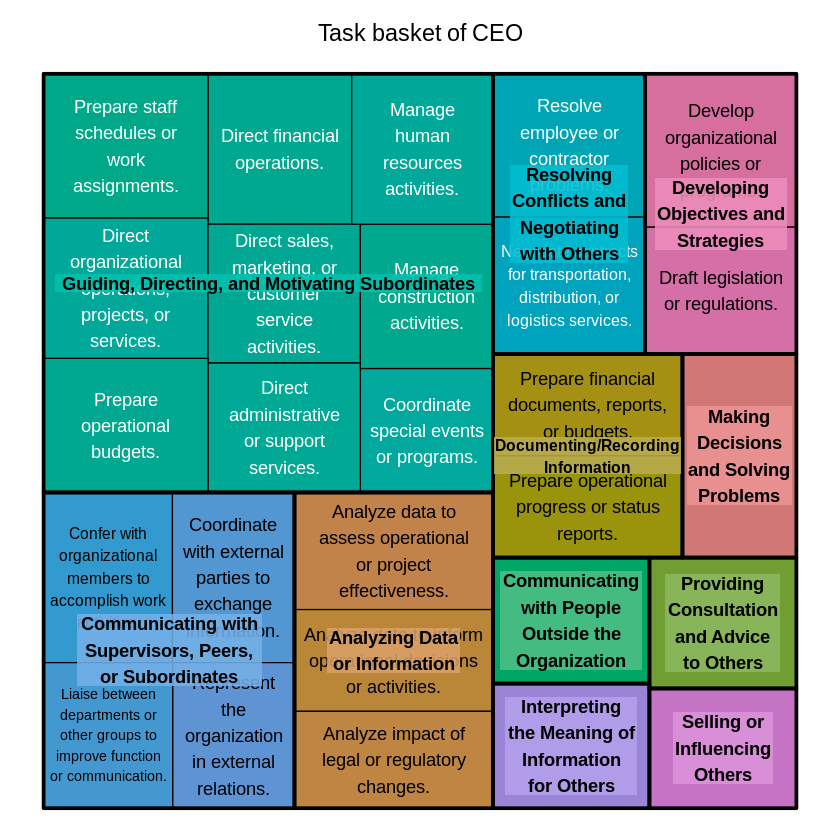

In [262]:
treemap(df_ceo_category,
  index = c("category", "DWA_Title"),
  vSize = "total_Imp",
  type = "index",
  title = "Task basket of CEO"
)

# Complexity weighted by Destination (Eg. profession) (example: Chief Executives)



You can also calculate economic complexity by destination.

We did this to explore opportunities for Ukraine (to connect to European value chains):

[https://growthlab.cid.harvard.edu/publications/assessing-ukraines-role-european-value-chains-gravity-equation-cum-economic](https://growthlab.cid.harvard.edu/publications/assessing-ukraines-role-european-value-chains-gravity-equation-cum-economic)

(Using the ECI by destination we found that highly complex products from Ukraine in the 2000s were typically destined for the Russian market, which was also one of the largest importers of products from Ukraine. The detoriation in relations with Russia led to a significant decline in exports there from 2011 onwards, resulting in Ukraine suffering from not only a quantitative but also a qualitative decline in exports).

Hidalgo and Hausmann (2009) calculate complexity of country $c$ as the average PCI of all products for which ${RCA}_{cp}>1$.

Below we define it as the weighted average PCI, where weights are given by the value of country $c$’s exports in each product. This allows us to define an ECI for separate export markets.

Let $\mathcal{M}$ be the set of countries that together constitute an export market (say, the EU&rsquo;s Single Market). Now, the destination-market specific ECI for country $c$ is defined as:

\begin{equation} \label{e_ECI}
ECI_{c}^{\mathcal{M}}=\sum \limits_{p} \frac{\sum \limits_{d \in \mathcal{M}} X^{d}_{op}}{\sum \limits_{d \in \mathcal{M}} X^{d}_{o}} {PCI}_{p}   
\end{equation}

where $X_{op}^{d}$ represents the exports of product $p$ from exporter $o$ to importer $d$ and an omitted subscript indicates the summation over the omitted category: $X_{o}^{d}=\sum \limits_{p} X_{op}^{d}$.

To calculate this, we need a dataset that has country exports **per destination** for this, which is available in the Growth Lab&rsquo;s DataVerse as:

    "country_partner_hsproduct4digit_years_2000_2016.csv"

As this file above is 16 gigabytes, we will load a version of it for only Ukraine&rsquo;s exports. This file has been processed outside of Google colab using the code below:

    df = pd.read_csv('country_partner_hsproduct4digit_years_2000_2016.csv')
    df = df[df['location_code_code']=='UKR')
    df = df[df['export_value']>0]
    df.to_csv('ukr_exports_per_destination.csv',index=False)



In [ ]:
# Complexity by destination
print('loading data')
#df_ukr <- read_csv(file='~/Dropbox/proj/org_zhtml_projects/product-space-eci-workshop/files/ukr_exports_per_destination.csv')
df_ukr <- read_csv(file='https://www.dropbox.com/s/megm8qzn3jcwnqz/ukr_exports_per_destination.csv?dl=1')
print('loaded')

# show sample of dataset
sample_n(df_ukr,10)

Merge PCI from products in 2000 into the dataframe (from df<sub>ec</sub> created in previous section using py-ecomplexity).



In [ ]:
# add leading zero if 3-digit
df_ukr$len_hs_product_code = str_length(df_ukr$hs_product_code)
df_ukr <- df_ukr %>%
    mutate(hs_product_code = ifelse(len_hs_product_code == 3, paste('0',hs_product_code,sep=""),hs_product_code))

# strip leading / trailing spaces
df_ukr$hs_product_code <- trimws(df_ukr$hs_product_code, which = c("both"))

# merge
df_ukr <- left_join(df_ukr, df_pci, by = c("hs_product_code" = "product_code"))

Now we calculate the ECI by destination:



In [ ]:
calc_ecimc <- function(data,origin_col,destination_col,task_col,value_col,pci_col) {
           dft <- data

           # total exports by exporter-importer
           dft <- dft %>%
             group_by(origin_col,destination_col) %>%
             mutate(export_value_cot = sum(value_col))

           # sum of pci per export
           dft$pci_x_export = dft$pci_col * dft$value_col

           dft <- dft %>%
             group_by(origin_col,destination_col) %>%
             mutate(pci_x_export_sum = sum(pci_x_export))

           dft$eciMc = dft$pci_x_export_sum / dft$export_value_cot

           dft <- dft %>%
             distinct(origin_col,destination_col, .keep_all= TRUE)

           dft <- dft %>% select(origin_col,destination_col,eciMc)

           return(dft)
         }

print('ecimc function defined')

In [ ]:
df_ukr_ecimc <- df_ukr %>%
  rename(origin_col = location_code,
         destination_col = partner_code,
         task_col = hs_product_code,
         value_col = export_value,
         pci_col = pci
  )

# calculate ecimc
df_ukr_ecimc <- calc_ecimc(data=df_ukr_ecimc,origin_col,destination_col,task_col,value_col,pci_col)

print('dataset eci weighted ready, sample below')

head(df_ukr_ecimc)

Economic complexity of Ukrainian exports by destination: most complex highlighted



In [ ]:
print ('need to install highcharter / maps but takes some time on google co-lab, hence not done at beginning')

###################
###################
ptm <- proc.time()
print('installing highcharter')
install.packages('highcharter',verbose=TRUE)
install.packages('highcharter') # slow install (in colab)
proc.time() - ptm

ptm <- proc.time()
print('installing maps')
install.packages('maps',verbose=TRUE)
install.packages('maps')
proc.time() - ptm
###################
###################

library('highcharter')
library('maps')

In [ ]:
df_ukr_ecimc_map <- df_ukr_ecimc %>%
  rename("iso-a3"="destination_col")

hcmap(
  map = "custom/world-highres3", # high resolution world map
  # eci in 85th percentile
  data = filter(df_ukr_ecimc_map,eciMc>quantile(df_ukr_ecimc_map$eciMc,probs=c(0.85),na.rm=TRUE)),
  joinBy = "iso-a3",
  value = "eciMc",
  showInLegend = FALSE, # hide legend
  #nullColor = "#DADADA",
  download_map_data = TRUE
) %>% hc_colorAxis(minColor = "orange", maxColor = "red")

In [ ]:
head(df_ukr_ecimc)

Highly complex products are typically destined for the Russian market, which is also one of the largest importers of products from Ukraine.

The detoriation in relations with Russia led to a significant decline in exports there from 2011 onwards:
![img](https://www.dropbox.com/s/xfl3gig3zxer0fm/total_exports_Ukraine_over_years.png?dl=1)

As a result, Ukraine suffers from not only a quantitative but also a qualitative decline in exports. In the paper we explore new opportunities for Ukraine.

(Note: double-check political controversies when using mapping libraries in R / Python (e.g. geopandas, highcharter)!)

![img](https://www.dropbox.com/s/twtl8p5ksgfezm0/map_ukraine.png?dl=1)



## Product space



### Overview



We now have a measure of similarity between products (and patents), which is the core of the product space.

[https://atlas.cid.harvard.edu/explore/network?country=114&year=2018&productClass=HS&product=undefined&startYear=undefined&target=Product&partner=undefined](https://atlas.cid.harvard.edu/explore/network?country=114&year=2018&productClass=HS&product=undefined&startYear=undefined&target=Product&partner=undefined)

![img](/Users/admin/Dropbox/proj/org_zhtml_projects/product-space-eci-workshop/imgs/product_space_atlas_website.png)

![img](https://www.dropbox.com/s/izag1xf28yldanf/product_space_atlas_website.png?dl=1)

Below we will explore the product space using R whilst interacting with Python. You can then directly manipulate the product space and visualize selectively if not possible in the Atlas interface (e.g. only products exported to certain countries).

The Github repo for this is available at [https://github.com/matteha/py-productspace](https://github.com/matteha/py-productspace).

What we need is information on:

-   Edges (ties) between nodes
    
    Ties between nodes represent the product proximity calculated above. Each product pair has a proximity value, but visualizing all ties, however, would result in a major &ldquo;hairball&rdquo;.
    
    To determine which of the ties to visualize in the product space, a &rsquo;maximum spanning tree algorithm&rsquo; is used (to make sure all nodes are connected directly or indirectly) in conjunction with a certain proximity threshold (0.55 minimum conditional probability). The details can be found in the Supplementary Material of Hidalgo et al. (2007) at [https://science.sciencemag.org/content/suppl/2007/07/26/317.5837.482.DC1](https://science.sciencemag.org/content/suppl/2007/07/26/317.5837.482.DC1).
    
    The data on the ties of nodes is available in the Atlas data repository at:
    [https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/FCDZBN/QSEETD&version=1.1](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/FCDZBN/QSEETD&version=1.1)
    
    We can directly load it into R using the link below (temporarily for this session, when using Harvard&rsquo;s dataverse you&rsquo;d need to sign a short User Agreement form so you can&rsquo;t load data directly from a URL):
    
    [https://www.dropbox.com/s/r601tjoulq1denf/network_hs92_4digit.json?dl=1](https://www.dropbox.com/s/r601tjoulq1denf/network_hs92_4digit.json?dl=1)

-   Position of nodes
    -   Each node is a product
    
    -   To position them in the product space, Hidalgo et al. (2007) used a spring embedding algorithm (which positions the nodes in such a way that there are as few crossing ties as possible, using physical simulations with force-directed algorithms), followed by hand-crafting the outcome to further visually separate distinct &rsquo;clusters&rsquo; of products.
        
        The data on the position of nodes (x, y coordinates) is in the same file as the one above with the data on ties (network<sub>hs92</sub><sub>4digit.json</sub>).
        
        We will use this fixed layout for now (James and Yang will deal with different ways to visualize multi-dimensional data in 2D/3D, e.g. with machine learning, UMAP).

-   Size of nodes
    
    The size in the product space represents the total $ in world trade, but one can also use other attributes of nodes (e.g. if nodes are industries, the size could be total employment).

-   Color of nodes
    
    In the product space the node color represents major product groups (e.g. Agriculture, Chemicals) following the Leamer classification. The node coloring data is available in the Atlas data repository at:
    [https://dataverse.harvard.edu/dataverse/atlas?q=&types=files&sort=dateSort&order=desc&page=1](https://dataverse.harvard.edu/dataverse/atlas?q=&types=files&sort=dateSort&order=desc&page=1)
    
    We can directly load it into R using the link below (again, temporary for this session):
    
    [https://www.dropbox.com/s/rlm8hu4pq0nkg63/hs4_hex_colors_intl_atlas.csv?dl=1](https://www.dropbox.com/s/rlm8hu4pq0nkg63/hs4_hex_colors_intl_atlas.csv?dl=1)



# (Visualizing in the product space, using R with Python)



Some (most) tools at the Growth Lab are written in Python / STATA rather than R, but with the &rsquo;reticulate&rsquo; package in R one can interact directly with Python libraries in the backend. Below is a showcase of one way to do so;

Yang&rsquo;s session (Session 3) will go much deeper into visualization as such using UMAP, machine learning etc.



#### Prepare dataframe



First we select the country which product portfolio we wish to visualize. We&rsquo;ll use Saudi Arabia below for the dataframe of the product space (&rsquo;df<sub>ps</sub>&rsquo;).



In [ ]:
   JOB_STRING <- 'Chief Executives'
 #JOB_STRING <- 'Tire Repairers and Changers'
df_ps <- df_rca %>%
  filter(job_col==JOB_STRING)

# Cross-check
if (dim(df_ps)[1]==0) {
    print('Country string set above does not exist in data, typed correctly?')
    STOP
}

##### Country, RCA, year, export value selections



Next we define what trade properties of Saudi Arabia we want to visualize. The example below visualizes specialiation in 2005 (year=2005, RCAcpt>1) of only those products with at least 40 million in trade value.

This data preparation happens before inputting into it the product space function so you can inspect the dataframe before plotting.



In [ ]:
df_ps <- 
df_rca %>%
  filter(job_col==JOB_STRING)   %>% 
    select(task_col,value_col, product_code)

To visualize the data in the product space, we will now use a Product Space visualization package by the Growth Lab written in Python (work in progress) at

[https://github.com/cid-harvard/py-productspace](https://github.com/cid-harvard/py-productspace)

The &rsquo;reticulate&rsquo; library in R allows one to (easily) incorporate python libraries in R:

[https://rstudio.github.io/reticulate/](https://rstudio.github.io/reticulate/)

Any Python module can be imported into and called from R (using &rsquo;import&rsquo;). For instance, we can import Python&rsquo;s os module and call the getcwd function to show the current working directory:



In [ ]:
os <- import("os")
os$getcwd()

Below we&rsquo;ll import into R the product space visualization library in Python and visualize Saudi Arabia&rsquo;s portfolio accordingly:



In [ ]:
# store df_ps dataframe in R's temporary folder before loading it into Python
file_name <- tempfile(fileext = ".csv")
write.csv(df_ps, file=file_name,row.names=FALSE)
 print(file_name)
 
# Call the python function from R
source_python('https://raw.githubusercontent.com/cid-harvard/py-productspace/master/create_product_space_v2.py')

# Filename of product space image (saved in R's temporary folder)
network_image_file_name <- tempfile(fileext=".png")

# To add R variables as Python parameters, we'll use the glue library
string_python <- glue("create_product_space(df_plot_dataframe_filename ='{file_name}', \\\
                     df_plot_node_col = 'task_col', \\\
                     df_node_size_col = 'value_col', \\\
                     output_image_file ='{network_image_file_name}')"
                     )

# Run the python string
py_run_string(string_python)

sprintf('product space image saved in %s',network_image_file_name)

# Plot the product space now

# -- load png file
pp <- readPNG(network_image_file_name)

# -- enlarge plot area in Jupyter Notebook
options(repr.plot.width=15, repr.plot.height=15)

# -- plot, enlarge width / height for higher resolution
grid::grid.raster(pp,width=1.8,height=1.8)

print('the network can be saved as an image locally by right clicking on it in the notebook
and clicking "Save Image", or by editing the output_image_file parameter above')

## -----------&#x2013;&#x2014; Break: Excercise 1 ------------------



### What product does Ukraine export most in 1995? (excluding services such as &rsquo;transport&rsquo;, &rsquo;ict&rsquo; etc)



In [ ]:
df_orig %>%
  filter(country_code == 'UKR' & year == 1995 & !is.na(as.numeric(product_code))) %>% 
  group_by(product_code,product_name) %>%
  summarise(sum_export_value = sum(export_value)) %>%
  arrange(desc(sum_export_value)) %>%
  head(1)

### What products is Ukraine specialized in in 1995 and 2005 and how much do they export of these?



### Which product is most related to the product &rsquo;Stainless steel wire&rsquo;?



### Plot Ukraine in the product space in 1995.



How would you characterize Ukraine&rsquo;s position in the product space?



### Plot Ukraine in the product space in 2015.



Do you notice a difference with 1995?



### Plot your own country across different years in the product space. Do the results make sense? Do you notice any patterns?



# Predicting diversification of countries: densities / density regressions



Shreyas will cover this.



# -----------&#x2013;&#x2014; Break: Excercise 2 ------------------



### What are countries with high complexity in 2015?



### Vice versa, what are countries with low complexity in 2015?



### What are products (PCI) with high complexity in 2015?



### Vice versa, what are products (PCI) with low complexity in 2015?



### Ukraine



#### How did Ukraine&rsquo;s economic complexity evolve over time?



#### How does Ukraine&rsquo;s economic complexity in 2015 compare to other countries? Which countries have comparable economic complexity?



#### What are the most complex products that Ukraine exported in 2015?



## ---



## ---



## ---



## Excercise answers



### Excercise 1



#### What product does Ukraine export most in 1995? (excluding services such as &rsquo;transport&rsquo;, &rsquo;ict&rsquo; etc)



In [ ]:
df_orig %>%
  filter(country_name=='Ukraine',year==2005) %>%
  group_by(product_code,product_name) %>%
  summarise(sum_export_value = sum(export_value)) %>%
  arrange(desc(sum_export_value)) %>%
  head()

#### What products is Ukraine specialized in in 1995 and 2005 and how much do they export of these?



In [ ]:
# Use the 'df_rca' dataframe for this
print('1995: ')
df_rca %>%
  filter(job_col=='Ukraine',time_col==1995) %>%
  arrange(desc(RCAcpt)) %>%
  select(task_col,RCAcpt,value_col) %>%
  head

print('2005: ')
df_rca %>%
  filter(job_col=='Ukraine',time_col==2005) %>%
  arrange(desc(RCAcpt)) %>%
  select(task_col,RCAcpt,value_col) %>%
  head

#### Which product is most related to the product &rsquo;Stainless steel wire&rsquo;?



In [ ]:
df_cppt %>%
  filter(task_col_1=='Stainless steel wire') %>%
  arrange(desc(phi)) %>%
  head()

#### Plot Ukraine in the product space in 1995.



How would you characterize Ukraine&rsquo;s position in the product space?



In [ ]:
df_ps <- df_rca %>%
  filter(job_col=='Ukraine', time_col==1995,RCAcpt>1,value_col > 4000000) %>%
  select(task_col,value_col,product_code)

file_name <- tempfile(fileext = ".csv")
write.csv(df_ps, file=file_name,row.names=FALSE)

# Call python functions from R
source_python('https://raw.githubusercontent.com/cid-harvard/py-productspace/master/create_product_space_v2.py')

# We will use the glue library here to add R variables as Python parameters
network_image_file_name <- tempfile(fileext=".png")

string_python <- glue("create_product_space(df_plot_dataframe_filename ='{file_name}', \\\
                     df_plot_node_col = 'product_code', \\\
                     df_node_size_col = 'value_col', \\\
                     output_image_file ='{network_image_file_name}')"
                     )

py_run_string(string_python)

sprintf('product space image saved in %s',network_image_file_name)

# Plot the product space now
pp <- readPNG(network_image_file_name)
options(repr.plot.width=15, repr.plot.height=15)
grid::grid.raster(pp,width=1.8,height=1.8)

print('the network can be saved as an image locally by right clicking on it in the notebook
and clicking "Save Image", or by editing the output_image_file parameter above')

#### Plot Ukraine in the product space in 2015.



Do you notice a difference with 1995?



In [ ]:
df_ps <- df_rca %>%
  filter(job_col=='Ukraine', time_col==2015,RCAcpt>1,value_col > 4000000) %>%
  select(task_col,value_col,product_code)

file_name <- tempfile(fileext = ".csv")
write.csv(df_ps, file=file_name,row.names=FALSE)

# Call python functions from R
source_python('https://raw.githubusercontent.com/cid-harvard/py-productspace/master/create_product_space_v2.py')

# We will use the glue library here to add R variables as Python parameters
network_image_file_name <- tempfile(fileext=".png")

string_python <- glue("create_product_space(df_plot_dataframe_filename ='{file_name}', \\\
                     df_plot_node_col = 'product_code', \\\
                     df_node_size_col = 'value_col', \\\
                     output_image_file ='{network_image_file_name}')"
                     )

py_run_string(string_python)

sprintf('product space image saved in %s',network_image_file_name)

# Plot the product space now
pp <- readPNG(network_image_file_name)
options(repr.plot.width=15, repr.plot.height=15)
grid::grid.raster(pp,width=1.8,height=1.8)

print('the network can be saved as an image locally by right clicking on it in the notebook
and clicking "Save Image", or by editing the output_image_file parameter above')

#### Plot your own country across different years in the product space. Do the results make sense? Do you notice any patterns?



### Excercise 2:



#### What are countries with high complexity in 2015?



In [ ]:
df_eci %>%
  arrange(desc(eci)) %>%
  head

#### Vice versa, what are countries with low complexity in 2015?



In [ ]:
df_eci %>%
  arrange(desc(eci)) %>%
  tail()

#### What are products (PCI) with high complexity in 2015?



In [ ]:
df_pci %>%
  arrange(desc(pci)) %>%
  head()

#### Vice versa, what are products (PCI) with low complexity in 2015?



In [ ]:
df_pci %>%
  arrange(desc(pci)) %>%
  tail()

#### Ukraine



##### How did Ukraine&rsquo;s economic complexity evolve over time?



In [ ]:
df_eci_allyrs <- data.frame()
years <- 1995:2016
  for (yeart in years) {
    sprintf('doing year %s',yeart)
    # Loop now
    head(df_orig)
    dft <- df_orig %>% filter(year==yeart) %>% select (country_name,product_name,export_value)
    dft <- dft %>%
      rename(country = country_name,
             product = product_name,
             value = export_value)
    # balassa index (rca, 1 if > 1)
    bi <- balassa_index(dft)
    # calculate eci / pci, using reflections here: same values as py-ecomplexity package
    cm <- complexity_measures(bi,method='reflections')
    # convert to tibble, add country names, sort from most to least complex
    # -- xci labels are set with setNames (extract with 'names')
    df_eci <- cm$complexity_index_country %>%
      as_tibble() %>%
      mutate(country = names(cm$complexity_index_country)) %>%
      rename(eci = value)
    df_eci$year = yeart
    head(df_eci)
    df_eci_allyrs <- bind_rows(df_eci_allyrs,df_eci)
  }

# plot eci over the years
dft <- filter(df_eci_allyrs,country == 'Ukraine')
dft %>% ggplot(aes(x = year, y = eci)) + geom_line()

##### How does Ukraine&rsquo;s economic complexity in 2015 compare to other countries? Which countries have comparable economic complexity?



In [ ]:
# - keep 2015, sort by eci and create row number
dft <- df_eci_allyrs %>%
  filter(year == 2015)  %>%
  arrange(desc(eci)) %>%
  mutate(row_number = row_number())
# countries above and below Ukraine in ranking
row_number1 <- filter(dft,country=='Ukraine')$row_number-5
row_number2 <- filter(dft,country=='Ukraine')$row_number+5
# show
dft %>% slice(row_number1:row_number2)

##### What are the most complex products that Ukraine exported in 2015?



In [ ]:
df_ukr <- df_rca %>%
  filter(time_col == 2015,job_col=='Ukraine',RCAcpt > 1)
# to merge pci into the dataframe, add leading zero if 3-digit
df_ukr$len_product_code = str_length(df_ukr$product_code)
df_ukr <- df_ukr %>%
    mutate(product_code = ifelse(len_product_code == 3, paste('0',product_code,sep=""),product_code))
# strip leading / trailing spaces
df_ukr$product_code <- trimws(df_ukr$product_code, which = c("both"))
# merge pcis from 2000 into dataframe
df_ukr <- left_join(df_ukr, df_pci, by = c("product_code" = "product_code"))
# sort
head(arrange(df_ukr,desc(pci)))
head(df_ukr,20)

## Questions?



Contact me at matte \_ hartog@hks.harvard.edu or drop by the fifth floor in the Rubenstein building, office 502.



## Patents: Country and city specializations over time, and technology proximities



We can apply this to patent data as well.

At the Growth Lab we have access to and worked with the Patstat database, patents from Google Bigquery, patents from PatentView, HistPat, and patents obtained from USPTO publications from 1790 onwards through optical character recognition.



### Technological diversification of countries



First we look at diversification of countries, using patents extracted from the Patstat database.

Patstat includes all patents from ~ 1903 onwards.

Below is an outline of what is available in Patstat:

![img](https://www.dropbox.com/s/zqgv7fi61c2ip2f/patstat.png?dl=1)

Below we use an aggregated file created from the Patstat database, containing:

-   Year
-   Country
-   Technology class
-   Count (N of patents)

which I put on Dropbox temporarily so we can load it in directly into Google CoLab.



#### Load patent data



In [ ]:
print('loading patent data')
# load STATA file into R directly from URL (using the 'foreign' library)
dfp <- read.dta('https://www.dropbox.com/s/nwox3dznoupzm0q/patstat_year_country_tech_inventor_locations.dta?dl=1')
#dfp <- read.dta('~/Dropbox/proj/org_zhtml_projects/product-space-eci-workshop/files/patstat_year_country_tech/patstat_year_country_tech_inventor_locations.dta')
print('patent data loaded')

##### Sample of data



In [ ]:
sample_n(dfp,10)

##### What are the first and last years in the data?



In [ ]:
min(dfp$year)
max(dfp$year)

##### How many countries and technology classes are in the data?



In [ ]:
print('Unique N of counties:')

length(unique(dfp$country_name))

print('Unique N of technologies:')

length(unique(dfp$tech))

#### RCAs



In [ ]:
# rename columns accordingly
dfp_rca <- dfp %>%
  rename(time_col = year,
         job_col = country_name,
         task_col = tech,
         value_col = count)

# calculate RCA
dfp_rca <- calc_rca(data=dfp_rca,job_col,task_col,time_col,value_col)

print('patent rcas ready')

##### What were Japan and Germany specialized in, in 1960 and 2010?



In [ ]:
countries <- list("Japan", "Germany")
years <- list(1960, 2010)
for (country in countries) {
  for (year in years) {
    dft <- dfp_rca %>%
      filter(job_col == country, time_col == year) %>%
      arrange(desc(RCAcpt)) %>%
      head
    print(dft)
  }
}

#### Technology proximities



What technology classes are most proximate (in 2010)?



In [ ]:
# Define Mcp
dfp_rca$Mcp = 0
dfp_rca <- dfp_rca %>%
  mutate(Mcp = ifelse(RCAcpt> 1, 1,0))

# Keep only years 2010 and only country-product combinations where Mcp == 1 (thus RCAcp > 1)
dft <-  dfp_rca %>%
  filter(time_col==2010,Mcp==1)

# Calculate cppt
dfp_cppt <- calc_cppt(data=dft,job_col,task_col)

print('cppt patent co-occurences and proximities dataframe ready')

# Show most proximate technologies
dfp_cppt %>%
  arrange(desc(phi)) %>%
  head(10)

(You can use density regressions as well here to predict technological diversification of countries. Shreyas will cover this Session 5).



### Technological diversification of cities in the USA



We can also investigate technological diversification at the sub-national level.

Below we&rsquo;re using patent counts per city per technology from 1975 onwards (obtained from patents extracted from the PatentView database). Patents&rsquo; technologies are defined according to the Cooperative Patent Classification (CPC).



#### Load patent data



In [ ]:
# load csv file into R directly from URL
print('loading patent data')
dfp <- read.csv('https://www.dropbox.com/s/th4zqkmuofmg4u3/patentview_class_2022.csv?dl=1')
#dfp <- read.csv('~/Dropbox/proj/odyssey_from/patentview_class_2022.csv')
print('patent data loaded')

##### Sample of data



In [ ]:
sample_n(dfp,10)

##### What are the first and last years in the data?



In [ ]:
min(dfp$year)
max(dfp$year)

##### How many cities (regions) and technology classes are in the data?



In [ ]:
print('Unique N of counties:')
length(unique(dfp$region))

print('Unique N of technologies:')
length(unique(dfp$tech))

#### RCAs



In [ ]:
# rename columns accordingly
dfp_rca <- dfp %>%
  rename(time_col = year,
         job_col = region,
         task_col = tech,
         value_col = count)

# calculate RCA
# -- keep 1980 and 2017
dfp_rca <- dfp_rca %>% filter(time_col==1980 | time_col == 2017)

# -- calculate
dfp_rca <- calc_rca(data=dfp_rca,job_col,task_col,time_col,value_col)

print('patent rcas ready')

##### What were Silicon Valley (Santa Clara county) and Detroit (MI - Wayne county) specialized in, in 1980 and 2017?



In [ ]:
# -- minimal 5 patents
regions <- list("CA > Santa Clara", "MI > Wayne")
years <- list(1980, 2017)
for (region in regions) {
  for (year in years) {
    dft <- dfp_rca %>%
      filter(grepl(region, job_col),time_col==year,value_col>5) %>%
      arrange(desc(RCAcpt)) %>%
      head
    print(dft)
  }
}

#### Technology proximities (cpc)



What technology classes (cpc classification) are most proximate (in 2010)?



In [ ]:
# Define Mcp
dfp_rca$Mcp = 0
dfp_rca <- dfp_rca %>%
  mutate(Mcp = ifelse(RCAcpt> 1, 1,0))

# Keep only years 2010 and only country-product combinations where Mcp == 1 (thus RCAcp > 1)
dft <-  dfp_rca %>%
  filter(time_col==2017,Mcp==1)

# Calculate cppt
dfp_cppt <- calc_cppt(data=dft,job_col,task_col)

print('df_cppt ready')
print('cppt patent co-occurences and proximities dataframe ready')

# Show most proximate technologies
dfp_cppt %>%
  arrange(desc(phi)) %>%
  head(10)